In [31]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import wfdb
import seaborn as sns
import os
import requests

from sklearn.svm import SVC,SVR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

from emg_processor import EMGProcessor
from emg_feature_extractor import EMGFeatureExtractor
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


import os
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from matplotlib.widgets import RangeSlider

In [91]:
CONSTANTS_MAP = {
        "6_67": {"sampling_rate": 250, "low_cutoff": 1, "high_cutoff": 40, "notch_freq": 50.0, "window_size": 37, "k": 200, "sec": 150},
        "8_57": {"sampling_rate": 250, "low_cutoff": 1, "high_cutoff": 40, "notch_freq": 50.0, "window_size": 29, "k": 257, "sec": 117},
        "12_0": {"sampling_rate": 250, "low_cutoff": 1, "high_cutoff": 40, "notch_freq": 50.0, "window_size": 20, "k": 360, "sec": 83},
        "15_0": {"sampling_rate": 250, "low_cutoff": 1, "high_cutoff": 40, "notch_freq": 50.0, "window_size": 16, "k": 450, "sec": 67},
        "1_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff":55 , "notch_freq": 50.0, "window_size": 147, "k": 51, "sec": 580},
        "10_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55, "notch_freq": 50.0, "window_size": 23, "k": 321, "sec": 94},
        "20_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55, "notch_freq": 50.0, "window_size": 12, "k": 621, "sec": 48},
        "30_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55.0, "notch_freq": 50.0, "window_size": 8, "k": 921, "sec": 32},
        "40_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55.0, "notch_freq": 50.0, "window_size": 6, "k": 1221, "sec": 25},
        "50_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55.0, "notch_freq": 50.0, "window_size": 5, "k": 1521, "sec": 20},
    }
subject="subject1_t1_t2_poor"


comparison_folders = ["6_67", "8_57", "12_0", "15_0"]
subfolders = ["l_0_25", "m_0_25", "r_0_25"]


# Functions

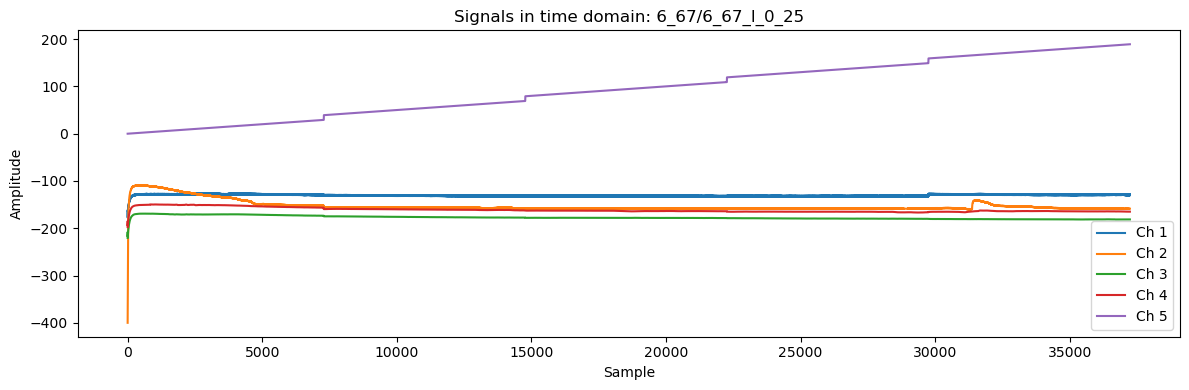

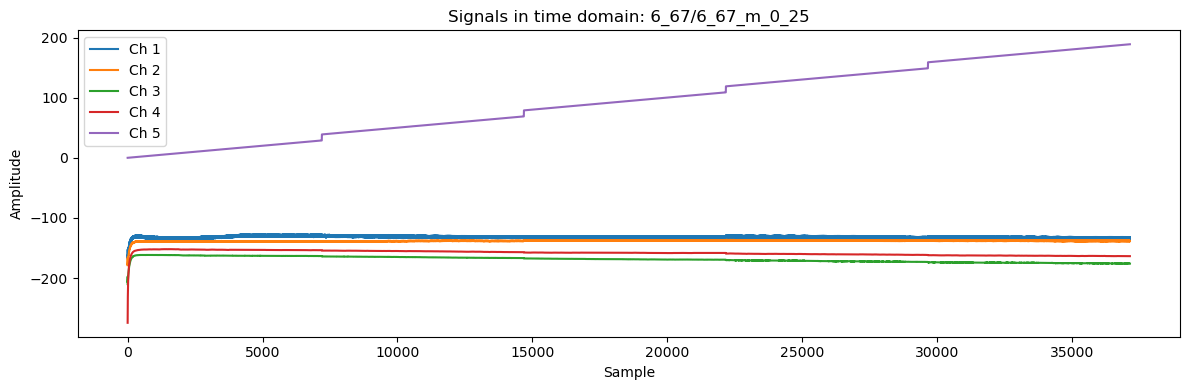

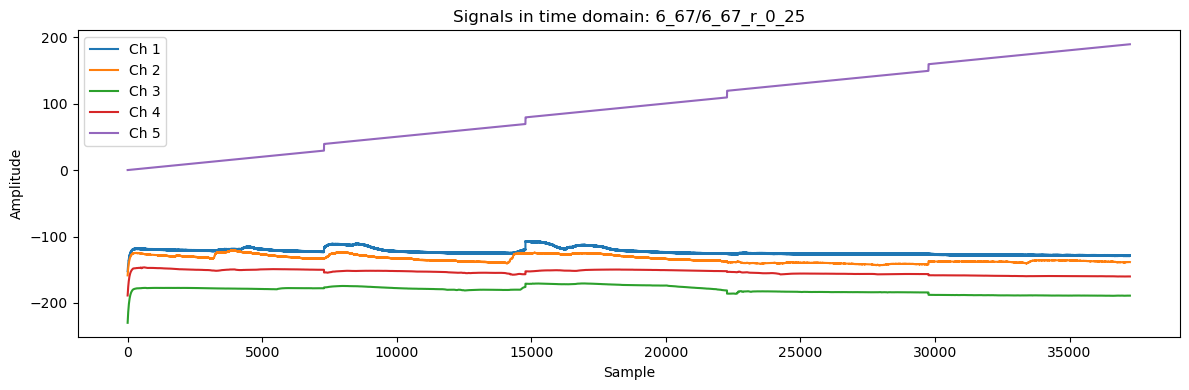

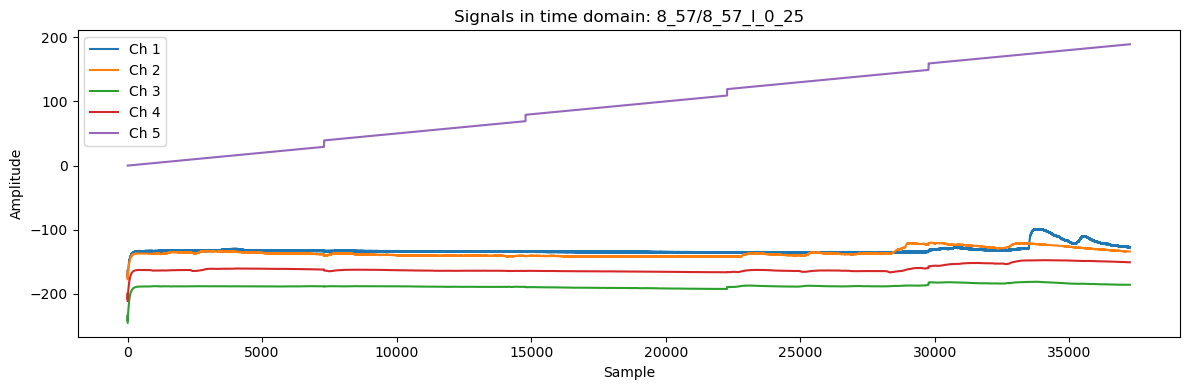

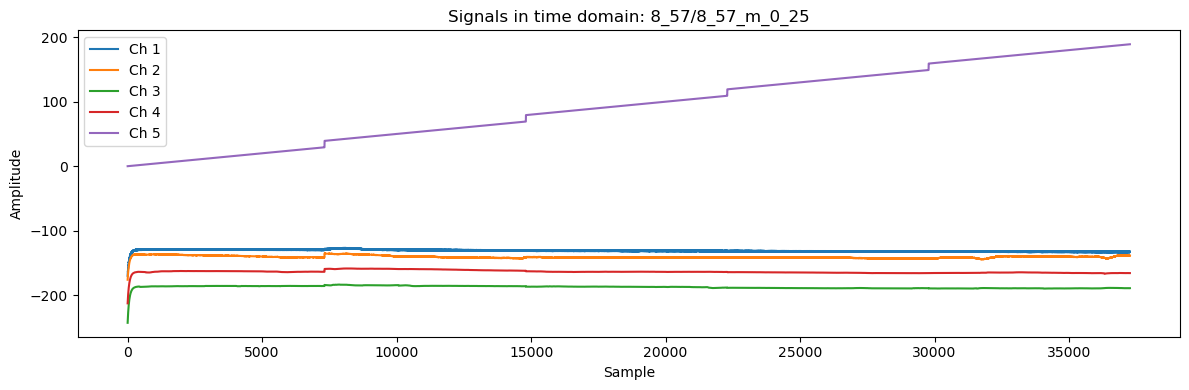

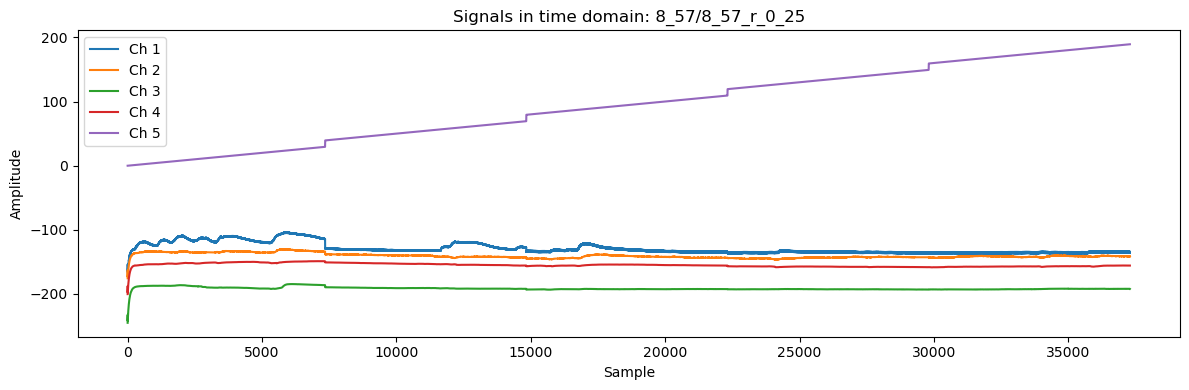

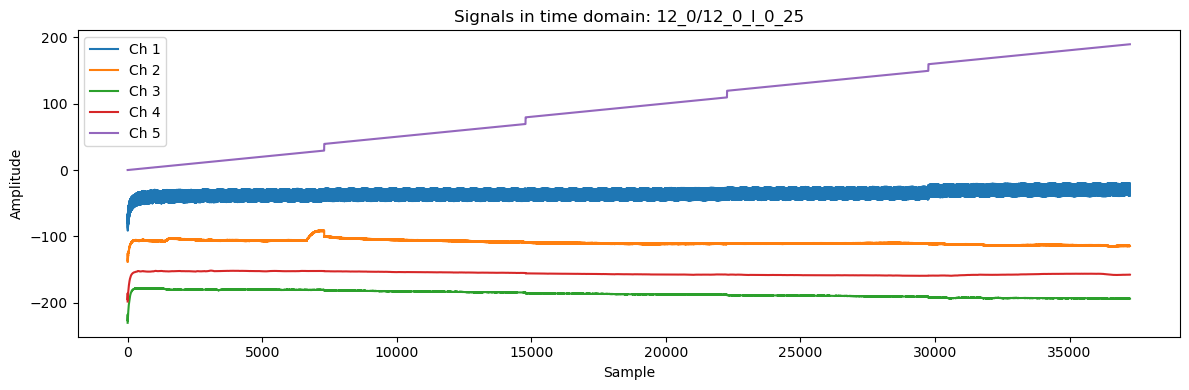

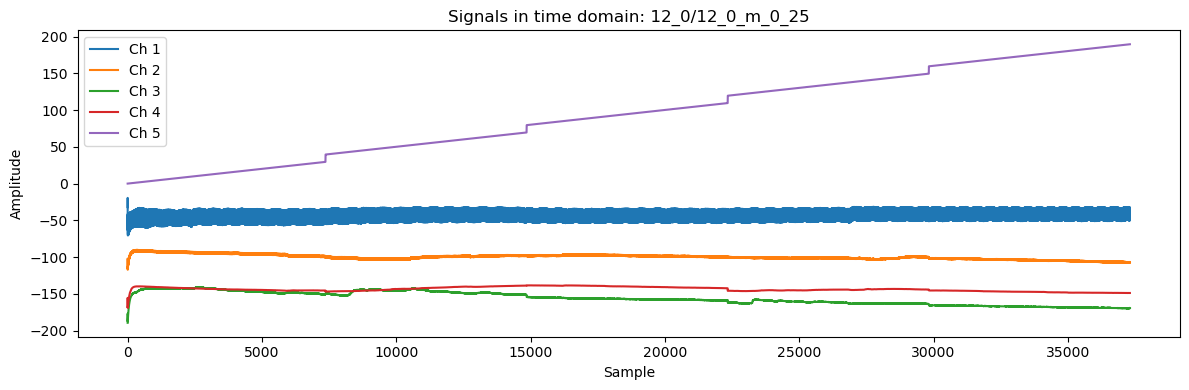

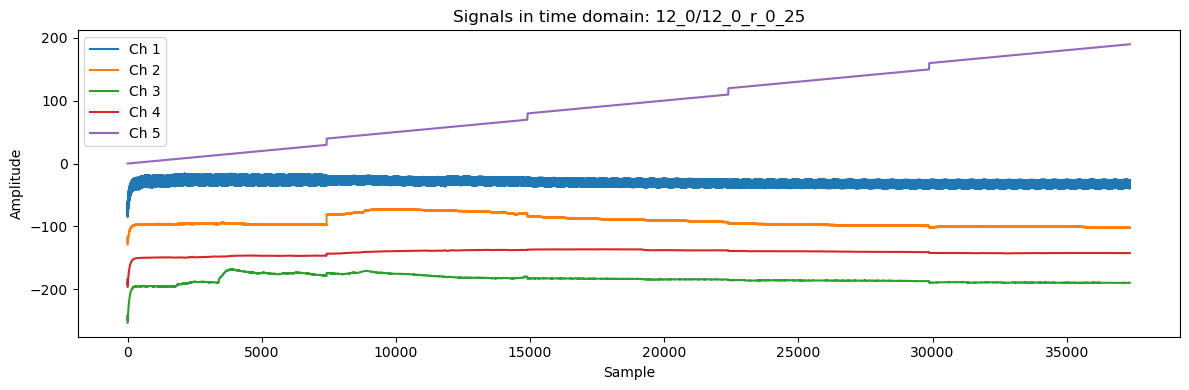

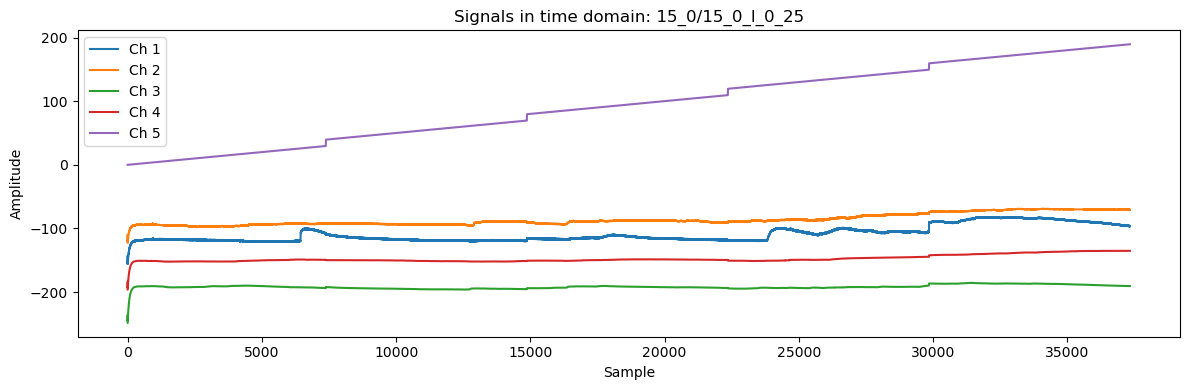

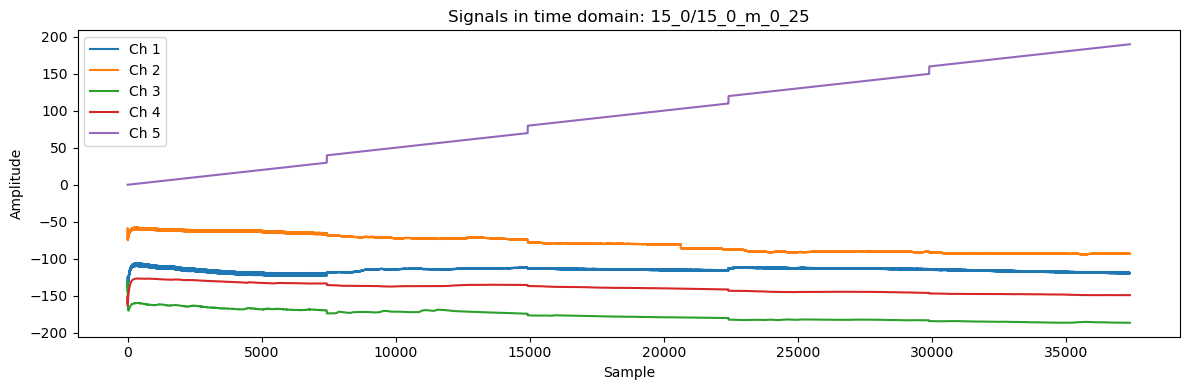

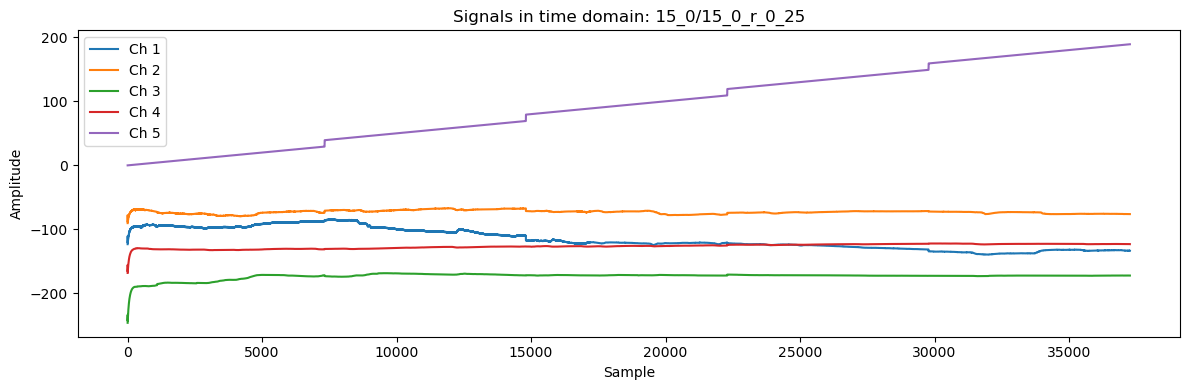

In [74]:


def convert_to_csv(record_path, output_csv_path):
    try:
        record = wfdb.rdrecord(record_path)
        signals = record.p_signal
        signal_names = record.sig_name
        df = pd.DataFrame(signals, columns=signal_names)
        df.to_csv(output_csv_path, index=False)
    except Exception as e:
        print(f"Error converting {record_path} to CSV: {e}")

def get_constants(comparison_folder):
    constants_map = CONSTANTS_MAP
    return constants_map.get(comparison_folder, None)

def read_eeg_data(base_path, comparison_folder, subfolder):
    folder_path = os.path.join(base_path, subject, comparison_folder, subfolder)
    constants = get_constants(comparison_folder)
    eeg_recording_path = os.path.join(folder_path, "eeg_recording")
    eeg_label_path = os.path.join(folder_path, "eeg_recording_label")
    record = wfdb.rdrecord(eeg_recording_path)
    signals = record.p_signal
    labels_record = wfdb.rdrecord(eeg_label_path)
    labels = labels_record.p_signal
    return signals, labels, constants

def process_all_folders(base_path):
    
    signals_dict, labels_dict, constants_dict = {}, {}, {}

    for comparison_folder in comparison_folders:
        constants = get_constants(comparison_folder)
        if not constants:
            continue
        constants_dict[comparison_folder] = constants
        signals_dict[comparison_folder] = {}
        labels_dict[comparison_folder] = {}

        for subfolder in subfolders:
            folder_name = f"{comparison_folder}_{subfolder}"
            try:
                signals, labels, _ = read_eeg_data(base_path, comparison_folder, folder_name)
                signals_dict[comparison_folder][folder_name] = signals
                labels_dict[comparison_folder][folder_name] = labels
            except Exception as e:
                print(f"Error processing folder {folder_name}: {e}")

    return signals_dict, labels_dict, constants_dict

def drop_zero_labels(signals_dict, labels_dict):
    for comp_key in signals_dict:
        for sub_key in signals_dict[comp_key]:
            sig = signals_dict[comp_key][sub_key]
            lab = labels_dict[comp_key][sub_key]
            mask = lab[:, 0] != 0.0 if lab.ndim > 1 else lab != 0.0
            signals_dict[comp_key][sub_key] = sig[mask]
            labels_dict[comp_key][sub_key] = lab[mask]

def scrollable_plot(signals, fs=250, win_sec=2, title=""):
    n_samples = signals.shape[0]
    t = np.arange(n_samples) / fs
    fig, ax = plt.subplots(figsize=(12, 4))
    for ch in range(signals.shape[1]):
        ax.plot(t, signals[:, ch], label=f'Ch {ch+1}')
    ax.set_xlim(0, win_sec)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.legend(loc="upper right")
    slider_ax = fig.add_axes([0.1, 0.05, 0.8, 0.04])
    rs = RangeSlider(slider_ax, "Window (s)", 0, t[-1], valinit=(0, win_sec), valstep=1/fs)
    rs.on_changed(lambda val: (ax.set_xlim(val), fig.canvas.draw_idle()))
    plt.show()

def plot_signals(signals_dict):
    for comp_key in signals_dict:
        for sub_key in signals_dict[comp_key]:
            signals = signals_dict[comp_key][sub_key]
            plt.figure(figsize=(12, 4))
            for ch in range(signals.shape[1]):
                plt.plot(signals[:, ch], label=f'Ch {ch+1}')
            plt.title(f"Signals in time domain: {comp_key}/{sub_key}")
            plt.xlabel("Sample")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.tight_layout()
            plt.show()

# Örnek kullanım
subject="subject1_t1_t2_poor"
base_path = "/Users/hafizenursahbudak/Desktop/WiSe 24/IDP/neurosamples-main-python-BrainBitDemo_SSVEP/python/BrainBitDemo/wfdb_data/data/"
signals_dict, labels_dict, constants_dict = process_all_folders(base_path)
drop_zero_labels(signals_dict, labels_dict)
plot_signals(signals_dict)


In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch

def apply_filter(data, sampling_rate, cutoff, filter_type='band', order=4):
    nyquist = 0.5 * sampling_rate
    norm_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, norm_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, data, axis=0)

def apply_notch_filter(data, sampling_rate, notch_freq=50.0, q=30.0):
    nyquist = 0.5 * sampling_rate
    norm_notch = notch_freq / nyquist
    b, a = iirnotch(norm_notch, q)
    return filtfilt(b, a, data, axis=0)

def normalize_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel) + 1e-8)



In [76]:

def plot_raw_and_filtered(signals_dict, constants_dict):
    os.makedirs(f"graphs/{subject}/raw", exist_ok=True)
    os.makedirs(f"graphs/{subject}/filtered", exist_ok=True)
    filtered_data_dict = {}

    for folder, subfolders in signals_dict.items():
        filtered_data_dict[folder] = {}
        const = constants_dict[folder]
        fs = const["sampling_rate"]
        low, high = const["low_cutoff"], const["high_cutoff"]
        notch = const["notch_freq"]

        for subfolder, signals in subfolders.items():
            try:
                signals = np.array(signals)
                signals_for_filter = signals[:, :4]  # Exclude marker (5th channel)

                # Plot raw (only channels 0 & 1 for visualization)
                t = np.linspace(0, len(signals) / fs, len(signals))
                plt.figure(figsize=(10, 4))
                plt.plot(t, signals[:, 0], label="Ch1", color="blue")
                plt.plot(t, signals[:, 1], label="Ch2", color="orange")
                plt.title(f'Raw: {subfolder}')
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(f"graphs/{subject}/raw/{folder}_{subfolder}_raw.png")
                plt.close()

                # Apply filters
                bandpassed = apply_filter(signals_for_filter, fs, [low, high])
                filtered = apply_notch_filter(bandpassed, fs, notch)

                # Save filtered data
                filtered_data_dict[folder][subfolder] = filtered

                # Plot filtered (only channels 0 & 1 for visualization)
                t_filt = np.linspace(0, len(filtered) / fs, len(filtered))
                plt.figure(figsize=(10, 4))
                plt.plot(t_filt, filtered[:, 0], label="Ch1", color="blue")
                plt.plot(t_filt, filtered[:, 1], label="Ch2", color="orange")
                plt.title(f'Filtered: {subfolder}')
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(f"graphs/{subject}/filtered/{folder}_{subfolder}_filtered.png")
                plt.close()

                print(f"[✔] Saved raw and filtered plots for {folder}/{subfolder}")

            except Exception as e:
                print(f"[ERROR] Plotting failed for {folder}/{subfolder}: {e}")

    return filtered_data_dict


def process_windows_and_plot(filtered_data_dict, constants_dict):
    os.makedirs(f"graphs/{subject}/filtered", exist_ok=True)

    for folder, subfolders in filtered_data_dict.items():
        if folder not in constants_dict:
            print(f"[SKIPPED] Unknown folder in constants: {folder}")
            continue

        const = constants_dict[folder]
        fs = const["sampling_rate"]
        win_size = const["window_size"]
        sec = const["sec"]

        for subfolder, data in subfolders.items():
            try:
                key = f"{folder}_{subfolder}"

                total_len = data.shape[0]
                if total_len < win_size:
                    print(f"[SKIPPED] Too short to window: {key}")
                    continue

                num_windows = total_len // win_size
                usable_len = num_windows * win_size

                if usable_len != total_len:
                    print(f"[INFO] Dropping last {total_len - usable_len} samples from {key}")

                data = data[:usable_len, :2]  # Only first 2 channels for windowing
                windows = data.reshape(num_windows, win_size, 2)

                avg = np.mean(windows, axis=0)
                std = np.std(windows, axis=0)

                norm_avg = np.stack([
                    normalize_channel(avg[:, 0]),
                    normalize_channel(avg[:, 1])
                ], axis=1)
                norm_std = np.stack([
                    std[:, 0] / (np.max(avg[:, 0]) - np.min(avg[:, 0]) + 1e-8),
                    std[:, 1] / (np.max(avg[:, 1]) - np.min(avg[:, 1]) + 1e-8)
                ], axis=1)

                t = np.linspace(0, sec, len(avg))

                # PLOT - RAW AVG
                plt.figure(figsize=(10, 4))
                plt.plot(t, avg[:, 0], label="Ch1 (Raw Avg)", color='blue')
                plt.plot(t, avg[:, 1], label="Ch2 (Raw Avg)", color='orange')
                plt.title(f"Windowed Raw Avg: {key}")
                plt.xlabel("Time (s)")
                plt.ylabel("Amplitude")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(f"graphs/{subject}/filtered/{key}_windowed_raw_avg.png")
                plt.close()

                # PLOT - NORMALIZED AVG
                plt.figure(figsize=(10, 4))
                plt.plot(t, norm_avg[:, 0], label="Ch1 (Norm)", color='blue')
                plt.plot(t, norm_avg[:, 1], label="Ch2 (Norm)", color='orange')
                plt.fill_between(t, norm_avg[:, 0] - norm_std[:, 0], norm_avg[:, 0] + norm_std[:, 0], alpha=0.2, color='blue')
                plt.fill_between(t, norm_avg[:, 1] - norm_std[:, 1], norm_avg[:, 1] + norm_std[:, 1], alpha=0.2, color='orange')
                plt.title(f"Normalized Windowed Avg + Std: {key}")
                plt.xlabel("Time (s)")
                plt.ylabel("Normalized Amplitude")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(f"graphs/{subject}/filtered/{key}_windowed_normalized.png")
                plt.close()

                print(f"[✔] Saved windowed and normalized plots for {key}")

            except Exception as e:
                print(f"[ERROR] Processing failed for {folder}/{subfolder}: {e}")


In [77]:
filtered_data_dict = plot_raw_and_filtered(signals_dict, constants_dict)
process_windows_and_plot(filtered_data_dict, constants_dict)


[✔] Saved raw and filtered plots for 6_67/6_67_l_0_25
[✔] Saved raw and filtered plots for 6_67/6_67_m_0_25
[✔] Saved raw and filtered plots for 6_67/6_67_r_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_l_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_m_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_r_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_l_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_m_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_r_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_l_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_m_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_r_0_25
[INFO] Dropping last 10 samples from 6_67_6_67_l_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_l_0_25
[INFO] Dropping last 35 samples from 6_67_6_67_m_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_m_0_25
[INFO] Dropping last 22 samples from 6_67_6_67_r_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_r_0_25
[INFO] 

In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA

def setup_mne_info(sampling_rate=250):
    ch_names = ['O1', 'O2', 'T7', 'T8']
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)
    info.set_montage('standard_1020')
    return info

def apply_ica_to_data(filtered_data_dict, constants_dict):
    os.makedirs(f"graphs/{subject}/ica", exist_ok=True)
    ica_results = {}

    for folder, subfolders in filtered_data_dict.items():
        ica_results[folder] = {}
        fs = constants_dict[folder]["sampling_rate"]

        for subfolder, data in subfolders.items():
            try:
                print(f"[→] Processing {folder}/{subfolder}: shape = {data.shape}")

                # İlk 4 kanalı al (son kanal marker, dışlanır)
                data_4ch = data[:, :4].T  # MNE için (channels, time)

                info = setup_mne_info(fs)
                raw = mne.io.RawArray(data_4ch, info, verbose=False)

                ica = ICA(n_components=4, random_state=97, max_iter=800, verbose=False)
                ica.fit(raw)

                ica_results[folder][subfolder] = {'ica': ica, 'raw': raw}

                # Save ICA components
                fig_comp = ica.plot_components(show=False)
                fig_comp[0].savefig(f"graphs/{subject}/ica/{folder}_{subfolder}_components.png")
                plt.close('all')

                # Save ICA sources
                fig_src = ica.plot_sources(raw, show=False, start=0, stop=5)
                fig_src.savefig(f"graphs/{subject}/ica/{folder}_{subfolder}_sources.png")
                plt.close(fig_src)

                print(f"[✔] ICA saved for {folder}/{subfolder}")

            except Exception as e:
                print(f"[✘] ICA failed for {folder}/{subfolder}: {e}")

    return ica_results


In [79]:
filtered_data_dict

{'6_67': {'6_67_l_0_25': array([[-1.86226134e+00, -6.47196335e+00, -2.12186056e+00,
          -1.87196034e+00],
         [-4.62988079e+00,  5.27095891e+00,  1.63886179e-01,
           4.56761286e-01],
         [-5.67734619e+00,  1.98934838e+01,  1.13078678e+00,
           1.45069177e+00],
         ...,
         [ 1.44447501e+00,  1.66399578e-01,  4.89713744e-02,
           1.63358921e-02],
         [ 9.89144572e-01,  1.15170979e-01,  3.81741529e-02,
           1.38154822e-02],
         [ 8.68451660e-02,  1.56830507e-02,  1.48769202e-02,
           8.91343714e-03]]),
  '6_67_m_0_25': array([[-1.53937145e+00, -1.72775643e+00, -2.00628580e+00,
          -3.29984674e+00],
         [-7.84121143e-01,  1.90685506e-01,  2.52869851e-01,
           2.66528309e+00],
         [-1.01414792e+00,  8.16370982e-01,  1.19467655e+00,
           8.29957460e+00],
         ...,
         [ 3.55714066e+00,  5.88183250e-01,  1.01164102e-01,
           4.32885974e-02],
         [ 2.42207437e+00,  3.98257539e-01

In [88]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_ica_4x2_grid(ica_results):
    os.makedirs(f"graphs/{subject}/ica", exist_ok=True)

    # Sadece ilk 4 dataset alınır
    datasets = [(folder, subfolder) for folder in ica_results for subfolder in ica_results[folder]]
    if len(datasets) == 0:
        print("No ICA results to plot.")
        return

    selected = datasets[:4]  # sadece ilk 4

    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    fig.suptitle('ICA Results (4x2 Grid)', fontsize=16, fontweight='bold')

    for idx, (folder, subfolder) in enumerate(selected):
        try:
            ica = ica_results[folder][subfolder]['ica']
            raw = ica_results[folder][subfolder]['raw']
            dataset_name = f"{folder}/{subfolder}"

            # COMPONENTS heatmap
            comp_data = ica.get_components()
            im = axes[idx, 0].imshow(comp_data, aspect='auto', cmap='RdBu_r', vmin=-0.8, vmax=0.8)
            axes[idx, 0].set_xticks(range(4))
            axes[idx, 0].set_xticklabels([f'IC{i}' for i in range(4)])
            axes[idx, 0].set_yticks(range(4))
            axes[idx, 0].set_yticklabels(['O1', 'O2', 'T7', 'T8'])
            axes[idx, 0].set_title(f'{dataset_name} - Components', fontweight='bold')
            plt.colorbar(im, ax=axes[idx, 0], shrink=0.8)

            # SOURCES time series
            sources = ica.get_sources(raw)
            sfreq = raw.info['sfreq']
            n_samples = min(int(5 * sfreq), sources.get_data().shape[1])
            time = np.arange(n_samples) / sfreq
            source_data = sources.get_data()[:, :n_samples]

            for i in range(4):
                norm = source_data[i] / np.std(source_data[i])
                offset = norm + i * 4
                axes[idx, 1].plot(time, offset, label=f'IC{i}')

            axes[idx, 1].set_xlim(0, 5)
            axes[idx, 1].set_xlabel("Flicker Screen Phase in Time Domain")
            axes[idx, 1].set_yticks([i*4 for i in range(4)])
            axes[idx, 1].set_yticklabels([f'IC{i}' for i in range(4)])
            axes[idx, 1].set_title(f'{dataset_name} - Sources')
            axes[idx, 1].legend(loc='upper right', fontsize=8)
            axes[idx, 1].grid(True, alpha=0.3)

        except Exception as e:
            print(f"[✘] Plotting failed for {folder}/{subfolder}: {e}")
            axes[idx, 0].text(0.5, 0.5, 'Error', ha='center', va='center')
            axes[idx, 1].text(0.5, 0.5, str(e), ha='center', va='center')

    # Kalan boş satır varsa kapat
    for idx in range(len(selected), 4):
        axes[idx, 0].axis("off")
        axes[idx, 1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    output_path = f"graphs/{subject}/ica/ica_4x2_grid.png"
    plt.savefig(output_path)
    plt.close()
    print(f"[✔] ICA 4x2 grid plot saved to {output_path}")


[→] Processing 6_67/6_67_l_0_25: shape = (37232, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 6_67/6_67_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 6_67/6_67_m_0_25: shape = (37146, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 6_67/6_67_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 6_67/6_67_r_0_25: shape = (37244, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 6_67/6_67_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_l_0_25: shape = (37250, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 8_57/8_57_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_m_0_25: shape = (37260, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 8_57/8_57_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_r_0_25: shape = (37288, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.1s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 8_57/8_57_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_l_0_25: shape = (37242, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 12_0/12_0_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_m_0_25: shape = (37308, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 12_0/12_0_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_r_0_25: shape = (37358, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 12_0/12_0_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_l_0_25: shape = (37330, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 15_0/15_0_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_m_0_25: shape = (37378, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 15_0/15_0_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_r_0_25: shape = (37264, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.4s.
[✘] ICA failed for 15_0/15_0_r_0_25: 'MNEFigure' object is not subscriptable
[✔] ICA 4x2 grid plot saved to graphs/subject1_t1_t2_poor/ica/ica_4x2_grid.png
Creating RawArray with float64 data, n_channels=4, n_times=37232
    Range : 0 ... 37231 =      0.000 ...   148.924 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_l_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37146
    Range : 0 ... 37145 =      0.000 ...   148.580 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_m_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37244
    Range : 0 ... 37243 =      0.000 ...   148.972 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_r_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37250
    Range : 0 ... 37249 =      0.000 ...   148.996 secs
Ready.
[✔] Saved components and sources for 8_57/8_57_l_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37260
    Range : 0 ... 37259 =   

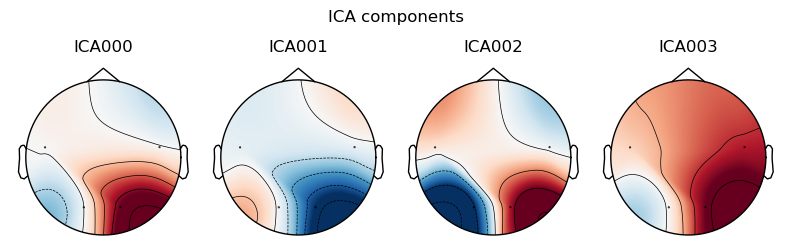

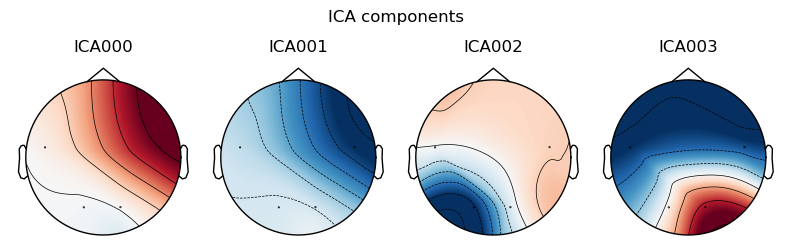

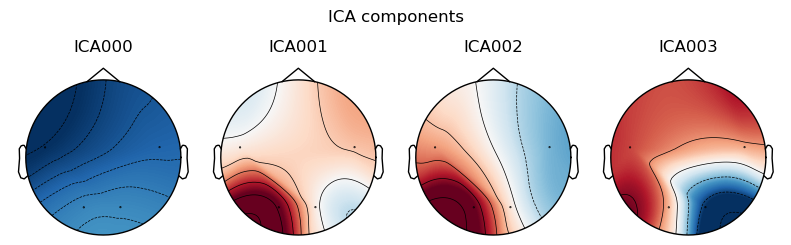

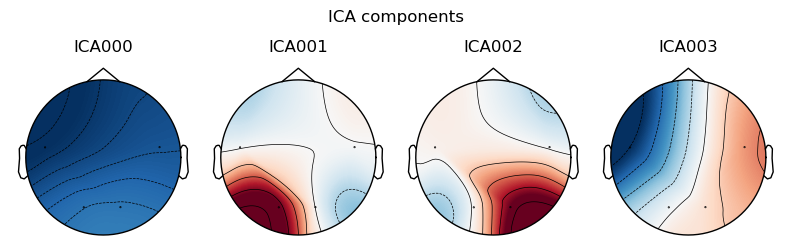

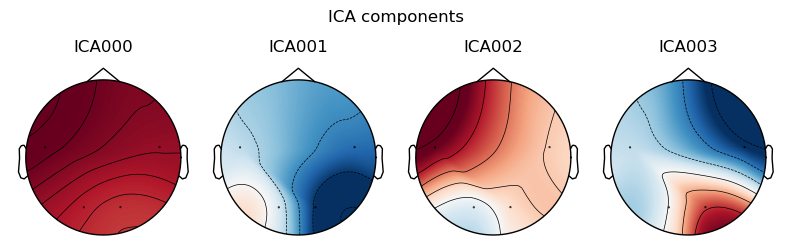

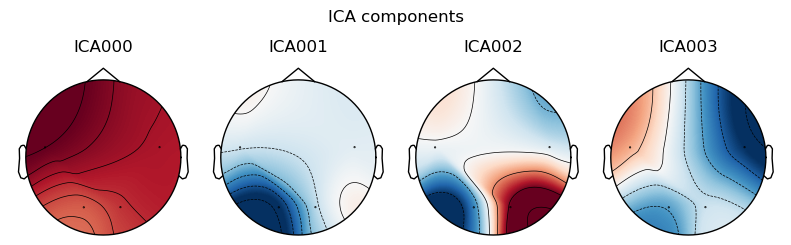

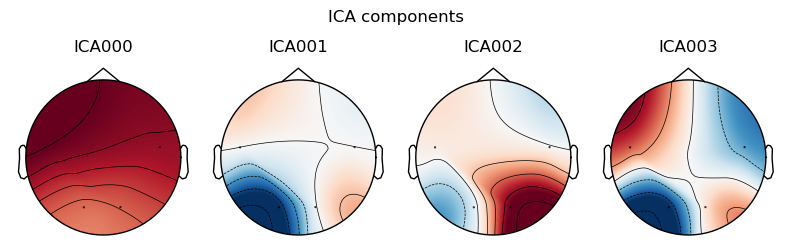

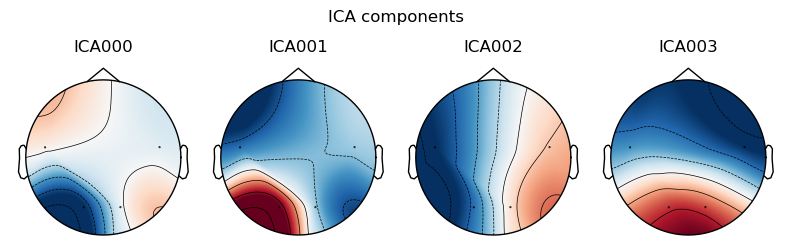

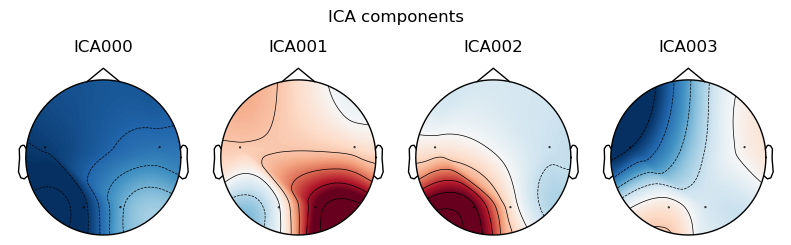

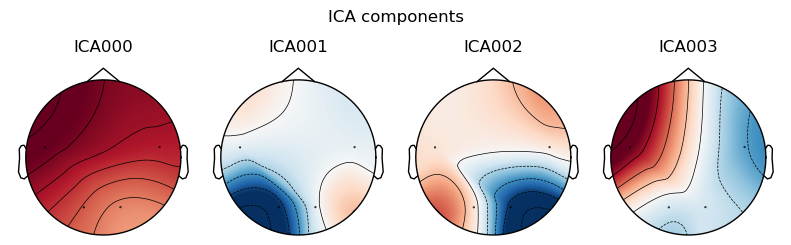

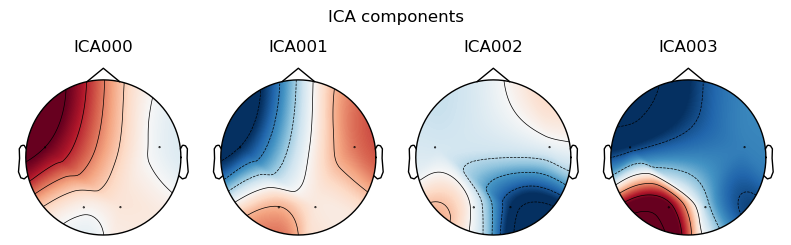

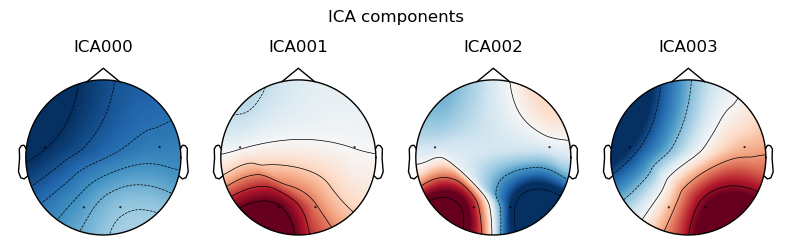

In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_ica_components(ica_results):
    """Plot ICA components and sources for each dataset and save to files"""
    os.makedirs(f"graphs/{subject}/ica", exist_ok=True)

    for folder, subfolders in ica_results.items():
        for subfolder, result in subfolders.items():
            try:
                ica = result['ica']
                raw = result['raw']
                name = f"{folder}_{subfolder}".replace("/", "_")

                # Plot components to file
                fig_comp = ica.plot_components(picks=np.arange(4), show=False)
                if isinstance(fig_comp, list):
                    fig_comp[0].suptitle(f'ICA Components - {folder}/{subfolder}', fontsize=14)
                    fig_comp[0].savefig(f"graphs/{subject}/ica/{name}_components.png")
                    plt.close(fig_comp[0])
                elif isinstance(fig_comp, plt.Figure):
                    fig_comp.suptitle(f'ICA Components - {folder}/{subfolder}', fontsize=14)
                    fig_comp.savefig(f"graphs/{subject}/ica/{name}_components.png")
                    plt.close(fig_comp)

                # Plot sources to file
                fig_sources = ica.plot_sources(raw, show=False, start=0, stop=5)
                fig_sources.suptitle(f'ICA Sources - {folder}/{subfolder}', fontsize=14)
                fig_sources.savefig(f"graphs/{subject}/ica/{name}_sources.png")
                plt.close(fig_sources)

                print(f"[✔] Saved components and sources for {folder}/{subfolder}")

            except Exception as e:
                print(f"[✘] Error plotting for {folder}/{subfolder}: {e}")
                
            


ica_results = apply_ica_to_data(filtered_data_dict, constants_dict)
plot_ica_4x2_grid(ica_results)
plot_ica_components(ica_results)


[→] Processing 6_67/6_67_l_0_25: shape = (37232, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.4s.
[✘] ICA failed for 6_67/6_67_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 6_67/6_67_m_0_25: shape = (37146, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.6s.
[✘] ICA failed for 6_67/6_67_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 6_67/6_67_r_0_25: shape = (37244, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.6s.
[✘] ICA failed for 6_67/6_67_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_l_0_25: shape = (37250, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.4s.
[✘] ICA failed for 8_57/8_57_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_m_0_25: shape = (37260, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.4s.
[✘] ICA failed for 8_57/8_57_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_r_0_25: shape = (37288, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.1s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 8_57/8_57_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_l_0_25: shape = (37242, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 12_0/12_0_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_m_0_25: shape = (37308, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 12_0/12_0_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_r_0_25: shape = (37358, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 12_0/12_0_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_l_0_25: shape = (37330, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 15_0/15_0_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_m_0_25: shape = (37378, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.4s.
[✘] ICA failed for 15_0/15_0_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_r_0_25: shape = (37264, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.4s.
[✘] ICA failed for 15_0/15_0_r_0_25: 'MNEFigure' object is not subscriptable
[ICA] 6_67/6_67_l_0_25 excluded: []
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
[ICA] 6_67/6_67_m_0_25 excluded: []
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
[ICA] 6_67/6_67_r_0_25 excluded: []
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
[ICA] 8_57/8_57_l_0_25 excluded: []
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
[ICA] 8_57/8_57_m_0_25 excluded: []
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projectin

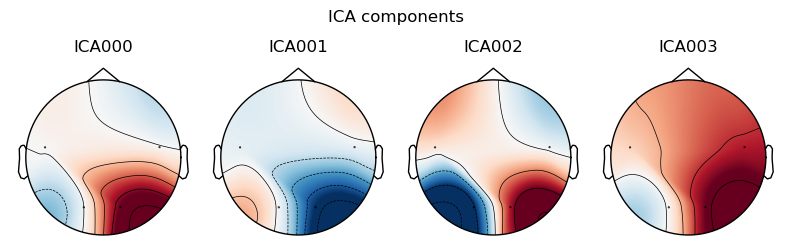

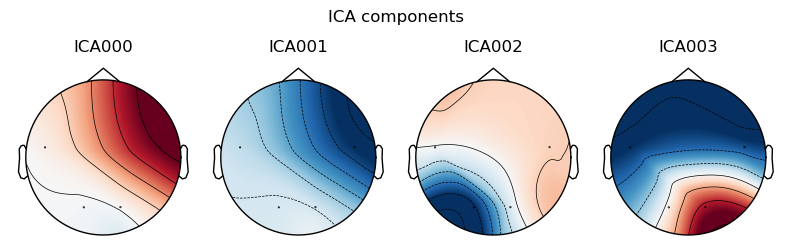

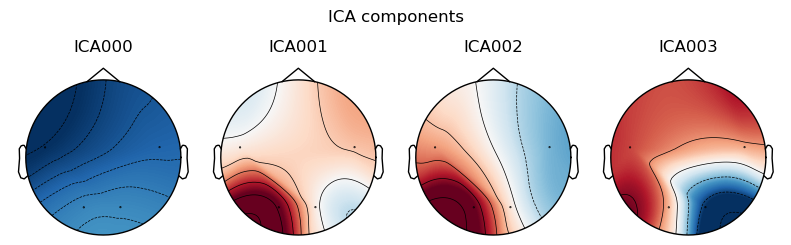

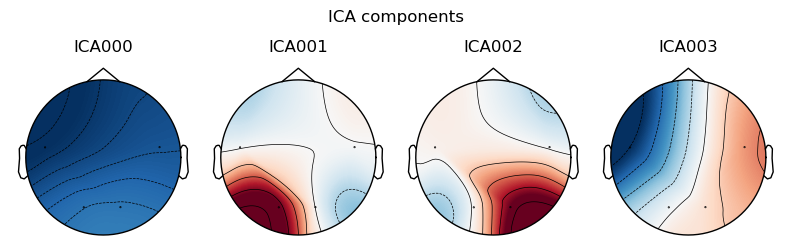

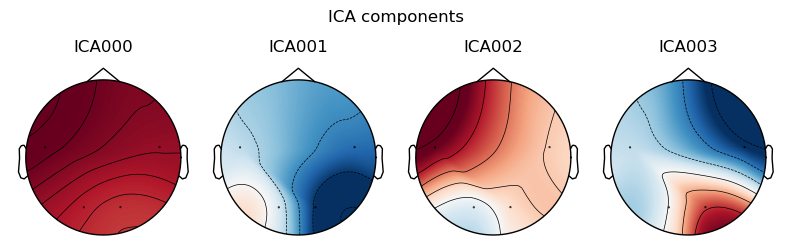

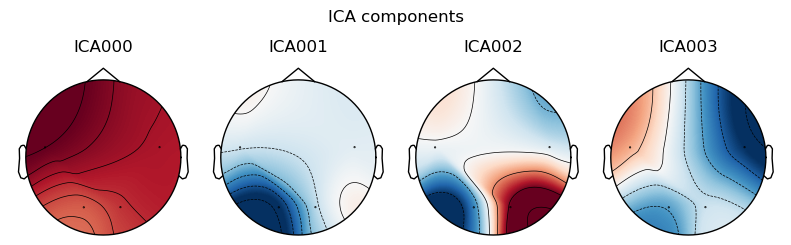

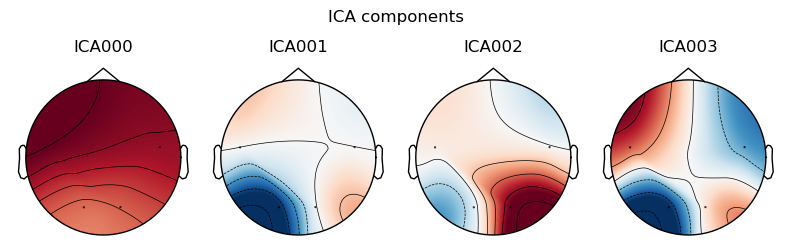

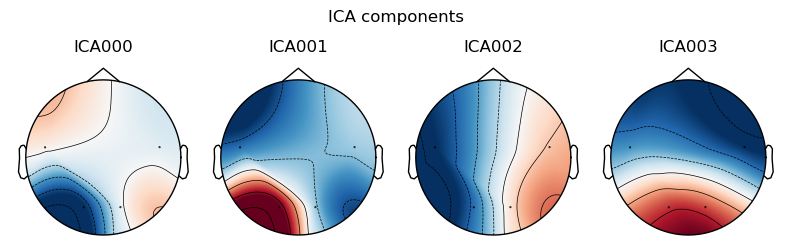

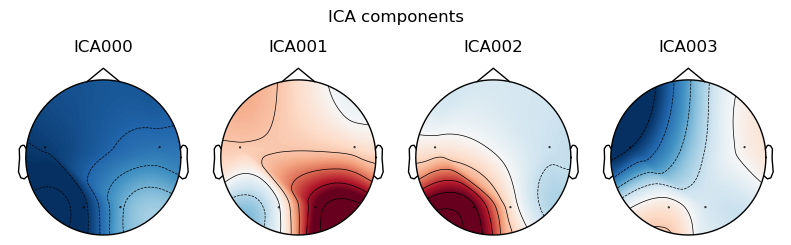

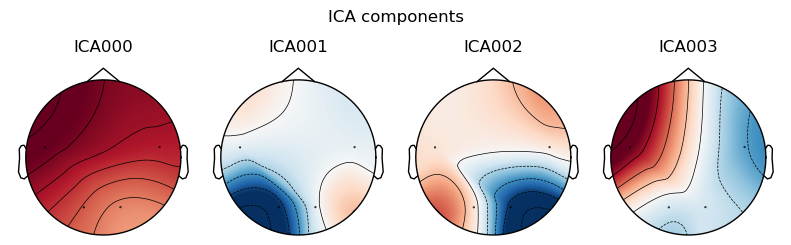

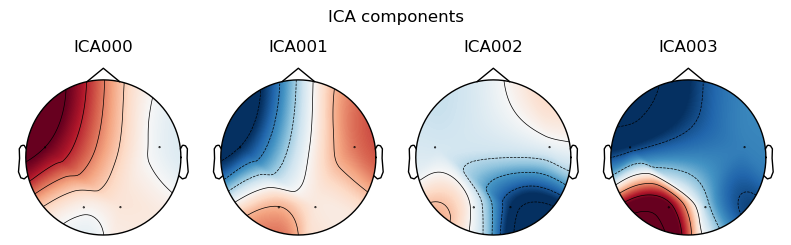

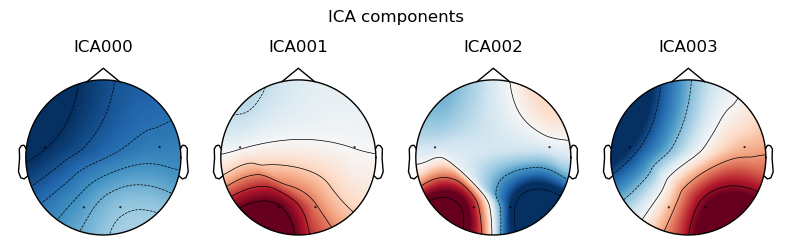

In [93]:
import os
import numpy as np
import mne
from sklearn.cross_decomposition import CCA

# === Konfigürasyonlar ===
frequencies = {
    '6_67': 6.67,
    '8_57': 8.57, 
    '12_0': 12.0,
    '15_0': 15.0
}

exclude_indices = {
    '6_67': {'6_67_m_1': [2, 3]},
    '8_57': {'8_57_m_1': [2, 3]},
    '12_0': {'12_0_m_1': [2, 3]},
    '15_0': {'15_0_m_1': [2, 3]}
}

epoch_params = {
    'duration': 29.5,   # Total epoch length (s)
    'trim_start': 1.0,  # Remove first 1s 
    'trim_end': 0.5     # Remove last 0.5s
}

# === Referans sinyali üretici ===
def create_ref_signals(freq, n_samples, sfreq):
    t = np.arange(n_samples) / sfreq
    return np.vstack([
        np.sin(2 * np.pi * freq * t),
        np.cos(2 * np.pi * freq * t),
        np.sin(4 * np.pi * freq * t),
        np.cos(4 * np.pi * freq * t)
    ]).T  # shape: (samples, 4)

# === ICA uygulaması ve temizleme ===
def apply_ica_cleaning(ica_results, exclude_map):
    cleaned_raws = {}
    for folder, subfolders in ica_results.items():
        cleaned_raws[folder] = {}
        for subfolder, result in subfolders.items():
            ica = result['ica']
            raw = result['raw']

            # Dışlanacak bileşenleri belirle
            exclude = exclude_map.get(folder, {}).get(subfolder, [])
            ica.exclude = exclude
            print(f"[ICA] {folder}/{subfolder} excluded: {exclude}")

            # Temiz veriyi oluştur
            cleaned_raw = ica.apply(raw.copy())
            cleaned_raws[folder][subfolder] = cleaned_raw
    return cleaned_raws

# === CCA sınıflandırması ===
def run_cca_classification(cleaned_raws, frequencies, epoch_params):
    results = {}

    for freq_key, freq_hz in frequencies.items():
        print(f"\n=== CCA Processing {freq_key} ({freq_hz}Hz) ===")
        results[freq_key] = {}

        for subfolder in subfolders:
            raw = cleaned_raws[freq_key][f"{freq_key}_{subfolder}"]

            # Epoch oluştur
            events = mne.make_fixed_length_events(raw, duration=epoch_params['duration'])
            epochs = mne.Epochs(
                raw, events,
                tmin=epoch_params['trim_start'],
                tmax=epoch_params['duration'] - epoch_params['trim_end'],
                baseline=None,
                preload=True
            )

            epoch_predictions = []
            for idx, epoch in enumerate(epochs.get_data()):
                X = epoch.T[:, :2]  # Sadece IC0 ve IC1
                freq_corrs = {}
                for test_freq_hz in frequencies.values():
                    Y = create_ref_signals(test_freq_hz, X.shape[0], raw.info['sfreq'])
                    cca = CCA(n_components=1)
                    cca.fit(X, Y)
                    X_c, Y_c = cca.transform(X, Y)
                    corr = np.corrcoef(X_c.T, Y_c.T)[0, 1]
                    freq_corrs[test_freq_hz] = corr

                best_freq = max(freq_corrs.items(), key=lambda x: x[1])[0]
                epoch_predictions.append(best_freq)

                print(f"{subfolder} - Epoch {idx+1}: Predicted = {best_freq:.2f}Hz")

            # Accuracy hesapla
            correct = sum(abs(p - freq_hz) < 0.5 for p in epoch_predictions)
            accuracy = correct / len(epoch_predictions)

            results[freq_key][subfolder] = {
                'predictions': epoch_predictions,
                'accuracy': accuracy,
                'epochs': epochs
            }

    return results


# === Sonuç raporu ===
def print_final_report(results, frequencies):
    print("\n=== Final Classification Report ===")
    for freq_key, freq_hz in frequencies.items():
        print(f"\nStimulus: {freq_key} ({freq_hz:.2f}Hz)")
        for subfolder, result in results[freq_key].items():
            pred_counts = {f: 0 for f in frequencies.values()}
            for pred in result['predictions']:
                pred_counts[pred] += 1

            print(f"  Subfolder: {subfolder}")
            for f, count in pred_counts.items():
                print(f"    {f:.2f}Hz: {count} epochs")
            print(f"    Accuracy: {result['accuracy']:.1%}")


# === Çalıştır ===
ica_results = apply_ica_to_data(filtered_data_dict, constants_dict)
cleaned_raws = apply_ica_cleaning(ica_results, exclude_indices)
results = run_cca_classification(cleaned_raws, frequencies, epoch_params)
print_final_report(results, frequencies)


In [94]:
import os
import matplotlib.pyplot as plt

import os
import matplotlib.pyplot as plt

def plot_cca_results(results, frequencies, output_dir=f"graphs/{subject}/plot"):
    os.makedirs(output_dir, exist_ok=True)

    for freq_key, freq_hz in frequencies.items():
        for subfolder, data in results[freq_key].items():
            predictions = data['predictions']
            accuracy = data['accuracy']

            # Sayım yap
            unique_freqs = list(frequencies.values())
            counts = {f: predictions.count(f) for f in unique_freqs}

            # Bar plot
            plt.figure(figsize=(8, 5))
            bars = plt.bar(
                [f"{f:.2f}Hz" for f in unique_freqs],
                [counts[f] for f in unique_freqs],
                color=["green" if abs(f - freq_hz) < 0.5 else "gray" for f in unique_freqs]
            )

            plt.title(f"{freq_key} ({freq_hz:.2f}Hz) - {subfolder}\nAccuracy: {accuracy:.1%}")
            plt.xlabel("Predicted Frequency")
            plt.ylabel("Number of Epochs")
            plt.grid(axis="y", linestyle="--", alpha=0.5)
            plt.ylim(0, max(counts.values()) + 1)

            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{int(height)}", ha='center')

            filename = os.path.join(output_dir, f"predictions_{freq_key}_{subfolder}.png")
            plt.tight_layout()
            plt.savefig(filename)
            plt.close()
            print(f"[✔] Plot saved to {filename}")

plot_cca_results(results, frequencies)


[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_6_67_l_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_6_67_m_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_6_67_r_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_8_57_l_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_8_57_m_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_8_57_r_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_12_0_l_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_12_0_m_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_12_0_r_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_15_0_l_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_15_0_m_0_25.png
[✔] Plot saved to graphs/subject1_t1_t2_poor/plot/predictions_15_0_r_0_25.png


In [96]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.cross_decomposition import CCA

def run_subepoch_analysis(
    cleaned_raws, frequencies, epoch_params, subepoch_duration=4.0, overlap=0.0,
    output_base="graphs"
):
    results = {}

    target_freqs = list(frequencies.values())

    for freq_key, freq_hz in frequencies.items():
        results[freq_key] = {}
        for subfolder in subfolders:
            print(f"\n=== {freq_key} ({freq_hz}Hz) | Subfolder: {subfolder} ===")
            raw = cleaned_raws[freq_key][f"{freq_key}_{subfolder}"]
            sfreq = raw.info['sfreq']

            output_dir = os.path.join(output_base, freq_key, subfolder, "vanilla")
            os.makedirs(output_dir, exist_ok=True)

            events = mne.make_fixed_length_events(raw, duration=epoch_params['duration'])
            epochs = mne.Epochs(
                raw, events,
                tmin=epoch_params['trim_start'],
                tmax=epoch_params['duration'] - epoch_params['trim_end'],
                baseline=None,
                preload=True
            )

            subepoch_preds = []

            for epoch_idx, epoch in enumerate(epochs.get_data()):
                n_samples = epoch.shape[1]
                step = int((subepoch_duration - overlap) * sfreq)
                subepoch_size = int(subepoch_duration * sfreq)

                for start in range(0, n_samples - subepoch_size + 1, step):
                    end = start + subepoch_size
                    subepoch = epoch[:2, start:end]  # IC0 ve IC1
                    X = subepoch.T
                    correlations = []

                    for test_freq in target_freqs:
                        t = np.arange(subepoch_size) / sfreq
                        Y = np.vstack([
                            np.sin(2 * np.pi * test_freq * t),
                            np.cos(2 * np.pi * test_freq * t),
                            np.sin(4 * np.pi * test_freq * t),
                            np.cos(4 * np.pi * test_freq * t)
                        ]).T

                        cca = CCA(n_components=1)
                        cca.fit(X, Y)
                        X_c, Y_c = cca.transform(X, Y)
                        corr = np.corrcoef(X_c.T, Y_c.T)[0, 1]
                        correlations.append(corr)

                    best_freq = target_freqs[np.argmax(correlations)]
                    subepoch_preds.append(best_freq)

                    print(f"Epoch {epoch_idx+1} | Subepoch {start//step+1}: Best Match = {best_freq:.2f}Hz")

            # Accuracy ve dağılım
            accuracy = sum(1 for p in subepoch_preds if abs(p - freq_hz) < 0.5) / len(subepoch_preds)
            dist = {f: subepoch_preds.count(f) for f in target_freqs}

            # Barplot
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.bar([str(f) for f in target_freqs], [dist[f] for f in target_freqs])
            ax.set_title(f"{freq_key} ({freq_hz}Hz) | {subfolder}\nAccuracy: {accuracy:.1%}")
            ax.set_xlabel("Predicted Frequency (Hz)")
            ax.set_ylabel("Count")
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{freq_key}_{subfolder}_subepoch_predictions.png"))
            plt.close()

            results[freq_key][subfolder] = {
                "target_frequency": freq_hz,
                "predictions": subepoch_preds,
                "accuracy": accuracy,
                "distribution": dist
            }

    return results

results = run_subepoch_analysis(cleaned_raws, frequencies, epoch_params)



=== 6_67 (6.67Hz) | Subfolder: l_0_25 ===
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
Epoch 1 | Subepoch 1: Best Match = 8.57Hz
Epoch 1 | Subepoch 2: Best Match = 8.57Hz
Epoch 1 | Subepoch 3: Best Match = 6.67Hz
Epoch 1 | Subepoch 4: Best Match = 6.67Hz
Epoch 1 | Subepoch 5: Best Match = 8.57Hz
Epoch 1 | Subepoch 6: Best Match = 8.57Hz
Epoch 1 | Subepoch 7: Best Match = 12.00Hz
Epoch 2 | Subepoch 1: Best Match = 6.67Hz
Epoch 2 | Subepoch 2: Best Match = 12.00Hz
Epoch 2 | Subepoch 3: Best Match = 8.57Hz
Epoch 2 | Subepoch 4: Best Match = 6.67Hz
Epoch 2 | Subepoch 5: Best Match = 8.57Hz
Epoch 2 | Subepoch 6: Best Match = 8.57Hz
Epoch 2 | Subepoch 7: Best Match = 8.57Hz
Epoch 3 | Subepoch 1: Best Match = 6.67Hz
Epoch 3 | Subepoch 2: Best Match = 6.67Hz
Epoch 3 | Subepoch 3: Best Match = 6.67Hz
Epoch 3 | Subepoch 4: Best Match = 8.5

In [97]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.cross_decomposition import CCA

def run_subepoch_analysis(cleaned_raws, frequencies, epoch_params, subepoch_duration=4.0, overlap=0.0, output_base="graphs"):
    target_freqs = list(frequencies.values())
    results = {}

    for freq_key, freq_hz in frequencies.items():
        print(f"\n=== {freq_key} ({freq_hz}Hz) Subepoch Analysis ===")
        results[freq_key] = {}

        for subfolder in subfolders:
            print(f"--> Processing subfolder: {subfolder}")
            raw = cleaned_raws[freq_key][f"{freq_key}_{subfolder}"]
            sfreq = raw.info['sfreq']
            output_dir = os.path.join(output_base, freq_key, subfolder)
            os.makedirs(output_dir, exist_ok=True)

            events = mne.make_fixed_length_events(raw, duration=epoch_params['duration'])
            epochs = mne.Epochs(
                raw, events,
                tmin=epoch_params['trim_start'],
                tmax=epoch_params['duration'] - epoch_params['trim_end'],
                baseline=None,
                preload=True
            )

            subepoch_preds = []

            for epoch_idx, epoch in enumerate(epochs.get_data()):
                n_samples = epoch.shape[1]
                step = int((subepoch_duration - overlap) * sfreq)
                subepoch_size = int(subepoch_duration * sfreq)

                for start in range(0, n_samples - subepoch_size + 1, step):
                    end = start + subepoch_size
                    subepoch = epoch[:2, start:end]
                    X = subepoch.T
                    t = np.arange(subepoch_size) / sfreq

                    correlations = []
                    all_Y = []

                    for test_freq in target_freqs:
                        Y = np.vstack([
                            np.sin(2 * np.pi * test_freq * t),
                            np.cos(2 * np.pi * test_freq * t),
                            np.sin(4 * np.pi * test_freq * t),
                            np.cos(4 * np.pi * test_freq * t)
                        ]).T
                        all_Y.append(Y)

                        cca = CCA(n_components=1)
                        cca.fit(X, Y)
                        X_c, Y_c = cca.transform(X, Y)
                        corr = np.corrcoef(X_c.T, Y_c.T)[0, 1]
                        correlations.append(corr)

                    best_freq = target_freqs[np.argmax(correlations)]
                    subepoch_preds.append(best_freq)

                    # === PLOT ===
                    best_Y = all_Y[np.argmax(correlations)]
                    cca = CCA(n_components=1)
                    cca.fit(X, best_Y)
                    X_c, Y_c = cca.transform(X, best_Y)

                    plt.figure(figsize=(10, 4))
                    plt.plot(X_c, label="EEG (CCA)")
                    plt.plot(Y_c, label=f"Ref Signal ({best_freq:.2f}Hz)", linestyle='--')
                    plt.title(f"{freq_key} - {subfolder} - Epoch {epoch_idx+1} Subepoch {start//step+1}\nBest Match: {best_freq:.2f}Hz | Corr: {max(correlations):.3f}")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude (CCA Component)")
                    plt.legend()
                    plt.grid(True, alpha=0.3)

                    plot_filename = f"{freq_key}_{subfolder}_ep{epoch_idx+1}_subep{start//step+1}.png"
                    plt.savefig(os.path.join(output_dir, plot_filename))
                    plt.close()

            # Doğruluk ve dağılım
            accuracy = sum(1 for p in subepoch_preds if abs(p - freq_hz) < 0.5) / len(subepoch_preds)
            dist = {f: subepoch_preds.count(f) for f in target_freqs}

            # Bar plot
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.bar([str(f) for f in target_freqs], [dist[f] for f in target_freqs])
            ax.set_title(f"{freq_key} - {subfolder} Subepoch Predictions\nAccuracy: {accuracy:.1%}")
            ax.set_xlabel("Predicted Frequency (Hz)")
            ax.set_ylabel("Count")
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{freq_key}_{subfolder}_subepoch_summary.png"))
            plt.close()

            results[freq_key][subfolder] = {
                "target_frequency": freq_hz,
                "predictions": subepoch_preds,
                "accuracy": accuracy,
                "distribution": dist
            }

    return results


results = run_subepoch_analysis(cleaned_raws, frequencies, epoch_params)



=== 6_67 (6.67Hz) Subepoch Analysis ===
--> Processing subfolder: l_0_25
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
--> Processing subfolder: m_0_25
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
--> Processing subfolder: r_0_25
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped

=== 8_57 (8.57Hz) Subepoch Analysis ===
--> Processing subfolder: l_0_25
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points

KeyboardInterrupt: 

<Figure size 1000x400 with 0 Axes>

In [126]:
import os
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

def create_ref_signals(freq, n_samples, sfreq):
    t = np.arange(n_samples) / sfreq
    return np.vstack([
        np.sin(2 * np.pi * freq * t),
        np.cos(2 * np.pi * freq * t),
        np.sin(4 * np.pi * freq * t),
        np.cos(4 * np.pi * freq * t)
    ]).T  # shape: (samples, 4)

from sklearn.cross_decomposition import CCA
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

def run_subepoch_analysis_with_normalization(
    cleaned_raws,
    frequencies,
    epoch_params,
    subepoch_duration=4.0,
    overlap=0.0
):
    """
    Returns a dict:
      { freq_key: {
           subfolder: {
             'target_frequency': ...,
             'predictions': [...],
             'accuracy': float
           }, ...
         }, ...
      }
    """
    results = {}

    for freq_key, freq_hz in frequencies.items():
        results[freq_key] = {}
        for subfolder in subfolders:
            print(f"\n=== {freq_key} ({freq_hz}Hz) | Subfolder: {subfolder} ===")
            raw = cleaned_raws[freq_key][f"{freq_key}_{subfolder}"]
            sfreq = raw.info['sfreq']

            save_dir = os.path.join("graphs", subject, freq_key, subfolder, "normalized")
            os.makedirs(save_dir, exist_ok=True)

            # epoch creation
            events = mne.make_fixed_length_events(raw, duration=epoch_params['duration'])
            epochs = mne.Epochs(raw, events,
                                tmin=epoch_params['trim_start'],
                                tmax=epoch_params['duration'] - epoch_params['trim_end'],
                                baseline=None, preload=True)

            subepoch_preds = []

            for epoch_idx, epoch in enumerate(epochs.get_data()):
                n_samples     = epoch.shape[1]
                subep_size    = int(subepoch_duration * sfreq)
                step_samples  = int((subepoch_duration - overlap) * sfreq)

                for start in range(0, n_samples - subep_size + 1, step_samples):
                    subepoch = epoch[:2, start:start+subep_size].T  # shape (samples, 2)
                    # z-score normalize
                    X = (subepoch - subepoch.mean(axis=0)) / subepoch.std(axis=0)

                    # compute correlations for each test_freq
                    corrs = {}
                    for test_freq in frequencies.values():
                        # create ref signal
                        t = np.arange(subep_size) / sfreq
                        Y = np.vstack([
                            np.sin(2*np.pi*test_freq*t),
                            np.cos(2*np.pi*test_freq*t),
                            np.sin(4*np.pi*test_freq*t),
                            np.cos(4*np.pi*test_freq*t),
                        ]).T
                        Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

                        cca = CCA(n_components=1)
                        cca.fit(X, Y)
                        Xc, Yc = cca.transform(X, Y)
                        corrs[test_freq] = np.corrcoef(Xc.T, Yc.T)[0, 1]

                    best = max(corrs, key=corrs.get)
                    subepoch_preds.append(best)

                    # (optional) save a plot of this subepoch
                    fig, ax = plt.subplots(figsize=(8,3))
                    ax.plot(np.arange(subep_size)/sfreq, X[:,0], label='IC0 (norm)')
                    ax.plot(np.arange(subep_size)/sfreq, Y[:,0], '--', label=f"Ref {best:.2f}Hz")
                    ax.set(title=f"{freq_key} E{epoch_idx+1} S{start//step_samples+1} → {best:.2f}Hz")
                    ax.legend(); ax.grid(True)
                    fig.savefig(os.path.join(
                        save_dir, f"{freq_key}_e{epoch_idx+1}_s{start//step_samples+1}.png"
                    ))
                    plt.close(fig)

            # compute overall accuracy for this subfolder
            correct = sum(abs(p - freq_hz) < 0.5 for p in subepoch_preds)
            accuracy = correct / len(subepoch_preds) if subepoch_preds else 0.0

            # store results
            results[freq_key][subfolder] = {
                'target_frequency': freq_hz,
                'predictions': subepoch_preds,
                'accuracy': accuracy
            }
            print(f"[Result] {freq_key}/{subfolder} → accuracy = {accuracy:.1%}")

    return results



In [147]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.cross_decomposition import CCA

def minmax_normalize(X):
    """Scale each column of X to the [0,1] range."""
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    return (X - X_min) / (X_max - X_min + 1e-8)

def run_subepoch_analysis_with_minmax(
    cleaned_raws,
    frequencies,
    epoch_params,
    subepoch_duration=4.0,
    overlap=0.0
):
    """
    Returns a dict:
      { freq_key: {
           subfolder: {
             'target_frequency': ...,
             'predictions': [...],
             'accuracy': float
           }, ...
         }, ...
      }
    """
    results = {}

    for freq_key, freq_hz in frequencies.items():
        results[freq_key] = {}
        for subfolder in subfolders:
            print(f"\n=== {freq_key} ({freq_hz}Hz) | Subfolder: {subfolder} (Min–Max) ===")
            raw = cleaned_raws[freq_key][f"{freq_key}_{subfolder}"]
            sfreq = raw.info['sfreq']

            save_dir = os.path.join("graphs", subject, freq_key, subfolder, "minmax")
            os.makedirs(save_dir, exist_ok=True)

            # epoch creation
            events = mne.make_fixed_length_events(raw, duration=epoch_params['duration'])
            epochs = mne.Epochs(
                raw, events,
                tmin=epoch_params['trim_start'],
                tmax=epoch_params['duration'] - epoch_params['trim_end'],
                baseline=None,
                preload=True
            )

            subepoch_preds = []

            for epoch_idx, epoch in enumerate(epochs.get_data()):
                n_samples    = epoch.shape[1]
                win          = int(subepoch_duration * sfreq)
                step_samples = int((subepoch_duration - overlap) * sfreq)

                for start in range(0, n_samples - win + 1, step_samples):
                    subep = epoch[:2, start:start+win].T  # (samples, 2)
                    X = minmax_normalize(subep)

                    # compute correlations against each reference
                    corrs = {}
                    t = np.arange(win) / sfreq
                    for test_freq in frequencies.values():
                        Y = np.vstack([
                            np.sin(2*np.pi*test_freq*t),
                            np.cos(2*np.pi*test_freq*t),
                            np.sin(4*np.pi*test_freq*t),
                            np.cos(4*np.pi*test_freq*t),
                        ]).T
                        Y = minmax_normalize(Y)

                        cca = CCA(n_components=1)
                        cca.fit(X, Y)
                        Xc, Yc = cca.transform(X, Y)
                        corrs[test_freq] = np.corrcoef(Xc.T, Yc.T)[0, 1]

                    best = max(corrs, key=corrs.get)
                    subepoch_preds.append(best)

                    # optional plotting
                    fig, ax = plt.subplots(figsize=(6, 3))
                    ax.plot(t, X[:, 0], label='IC0 (minmax)')
                    ax.plot(t, Y[:, 0], '--', label=f"Ref @ {best:.2f}Hz")
                    ax.set(title=f"{freq_key} E{epoch_idx+1} S{start//step_samples+1}")
                    ax.legend(fontsize=8); ax.grid(True, alpha=0.3)
                    fig.savefig(os.path.join(
                        save_dir,
                        f"{freq_key}_e{epoch_idx+1}_s{start//step_samples+1}.png"
                    ))
                    plt.close(fig)

            # compute accuracy
            correct  = sum(abs(p - freq_hz) < 0.5 for p in subepoch_preds)
            accuracy = correct / len(subepoch_preds) if subepoch_preds else 0.0

            results[freq_key][subfolder] = {
                'target_frequency': freq_hz,
                'predictions': subepoch_preds,
                'accuracy': accuracy
            }
            print(f"[Result] {freq_key}/{subfolder} → accuracy = {accuracy:.1%}")

    return results

# Usage example:
# subfolders = ["l_0_25","m_0_25","r_0_25"]
# minmax_results = run_subepoch_analysis_with_minmax(
#     cleaned_raws,
#     frequencies,
#     epoch_params,
#     subfolders,
#     subject="subject1_t1_t2_poor",
#     subepoch_duration=4.0,
#     overlap=0.0
# )


In [ ]:
normalized_subepoch_results = run_subepoch_analysis_with_normalization(
    cleaned_raws,
    frequencies,
    epoch_params,
    subepoch_duration=4.0,
    overlap=0.0,
)



AttributeError: 'list' object has no attribute 'items'

In [160]:
def summarize_normalized_subepoch_results(results, frequency_list):
    """
    results: dict of the form
      { freq_key: {
           subfolder: {
             'target_frequency': float,
             'predictions': [...],
             'accuracy': float
           }, ...
         }, ...
      }
    frequency_list: list of true frequency values, e.g. [6.67, 8.57, 12.0, 15.0]
    """
    print("\n=== Subepoch CCA Classification Summary ===")
    for freq_key, subdict in results.items():
        print(f"\nFrequency group: {freq_key}")
        for subfolder, entry in subdict.items():
            # sanity checks
            if not isinstance(entry, dict):
                print(f"[!] Entry for {freq_key}/{subfolder} is not a dict, skipping.")
                continue
            preds = entry.get('predictions')
            target = entry.get('target_frequency')
            if preds is None:
                print(f"[!] Missing 'predictions' for {freq_key}/{subfolder}, skipping.")
                continue
            if target is None:
                print(f"[!] Missing 'target_frequency' for {freq_key}/{subfolder}, skipping.")
                continue

            total   = len(preds)
            correct = sum(abs(p - target) < 0.5 for p in preds)
            accuracy = correct / total if total else 0.0

            # print the summary line
            print(f"  {subfolder}: Target = {target:.2f} Hz, "
                  f"Accuracy = {accuracy:.1%} ({correct}/{total})")

            # optional: distribution
            dist = {f: preds.count(f) for f in frequency_list}
            for f, cnt in dist.items():
                pct = cnt/total if total else 0
                print(f"    → {f:.2f} Hz: {cnt} times ({pct:.1%})")



# Kullanım:
summarize_normalized_subepoch_results(normalized_subepoch_results, list(frequencies.values()))



=== Subepoch CCA Classification Summary ===

Frequency group: 6_67
  l_0_25: Target = 6.67 Hz, Accuracy = 25.7% (9/35)
    → 6.67 Hz: 9 times (25.7%)
    → 8.57 Hz: 22 times (62.9%)
    → 12.00 Hz: 4 times (11.4%)
    → 15.00 Hz: 0 times (0.0%)
  m_0_25: Target = 6.67 Hz, Accuracy = 42.9% (15/35)
    → 6.67 Hz: 15 times (42.9%)
    → 8.57 Hz: 17 times (48.6%)
    → 12.00 Hz: 3 times (8.6%)
    → 15.00 Hz: 0 times (0.0%)
  r_0_25: Target = 6.67 Hz, Accuracy = 31.4% (11/35)
    → 6.67 Hz: 11 times (31.4%)
    → 8.57 Hz: 23 times (65.7%)
    → 12.00 Hz: 1 times (2.9%)
    → 15.00 Hz: 0 times (0.0%)

Frequency group: 8_57
  l_0_25: Target = 8.57 Hz, Accuracy = 74.3% (26/35)
    → 6.67 Hz: 8 times (22.9%)
    → 8.57 Hz: 26 times (74.3%)
    → 12.00 Hz: 1 times (2.9%)
    → 15.00 Hz: 0 times (0.0%)
  m_0_25: Target = 8.57 Hz, Accuracy = 74.3% (26/35)
    → 6.67 Hz: 6 times (17.1%)
    → 8.57 Hz: 26 times (74.3%)
    → 12.00 Hz: 2 times (5.7%)
    → 15.00 Hz: 1 times (2.9%)
  r_0_25: Target 

In [159]:
normalized_subepoch_results

{'6_67': {'l_0_25': {'target_frequency': 6.67,
   'predictions': [8.57,
    8.57,
    6.67,
    6.67,
    8.57,
    8.57,
    12.0,
    6.67,
    12.0,
    8.57,
    6.67,
    8.57,
    8.57,
    8.57,
    6.67,
    6.67,
    6.67,
    8.57,
    8.57,
    8.57,
    8.57,
    12.0,
    8.57,
    8.57,
    12.0,
    8.57,
    8.57,
    6.67,
    8.57,
    8.57,
    8.57,
    8.57,
    6.67,
    8.57,
    8.57],
   'accuracy': 0.2571428571428571},
  'm_0_25': {'target_frequency': 6.67,
   'predictions': [8.57,
    6.67,
    6.67,
    6.67,
    6.67,
    8.57,
    6.67,
    12.0,
    8.57,
    6.67,
    6.67,
    6.67,
    6.67,
    8.57,
    8.57,
    6.67,
    8.57,
    8.57,
    8.57,
    8.57,
    6.67,
    8.57,
    8.57,
    8.57,
    12.0,
    8.57,
    8.57,
    12.0,
    6.67,
    8.57,
    6.67,
    6.67,
    6.67,
    8.57,
    8.57],
   'accuracy': 0.42857142857142855},
  'r_0_25': {'target_frequency': 6.67,
   'predictions': [6.67,
    6.67,
    8.57,
    8.57,
    6.67,
    1

In [145]:



def minmax_normalize(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-8)

def run_subepoch_analysis_with_minmax(
    cleaned_raws, frequencies, epoch_params
    subepoch_duration=4.0, overlap=0.0,
    output_base="graphs"
):
    results = {}
    
    for freq_key, freq_hz in frequencies.items():
        print(f"\n=== {freq_key} ({freq_hz}Hz) için analiz başlatılıyor ===")
        results[freq_key] = {}

        for subfolder in subfolders:
            print(f"--> İşleniyor: {subfolder}")
            raw = cleaned_raws[freq_key][f"{freq_key}_{subfolder}"]
            sfreq = raw.info['sfreq']

            save_dir = os.path.join(output_base, freq_key, subfolder, "minmax")
            os.makedirs(save_dir, exist_ok=True)

            events = mne.make_fixed_length_events(raw, duration=epoch_params['duration'])
            epochs = mne.Epochs(
                raw, events,
                tmin=epoch_params['trim_start'],
                tmax=epoch_params['duration'] - epoch_params['trim_end'],
                baseline=None,
                preload=True
            )

            subepoch_preds = []

            for epoch_idx, epoch in enumerate(epochs.get_data()):
                n_samples = epoch.shape[1]
                subepoch_size = int(subepoch_duration * sfreq)
                step = int((subepoch_duration - overlap) * sfreq)

                for start in range(0, n_samples - subepoch_size + 1, step):
                    end = start + subepoch_size
                    subepoch = epoch[:2, start:end]
                    X = minmax_normalize(subepoch.T)

                    correlations = {}
                    ref_signals_all = {}

                    for test_freq in frequencies.values():
                        Y = create_ref_signals(test_freq, subepoch_size, sfreq)
                        Y = minmax_normalize(Y)
                        ref_signals_all[test_freq] = Y.copy()

                        cca = CCA(n_components=1)
                        cca.fit(X, Y)
                        X_c, Y_c = cca.transform(X, Y)
                        corr = np.corrcoef(X_c.T, Y_c.T)[0, 1]
                        correlations[test_freq] = corr

                    best_freq = max(correlations.items(), key=lambda x: x[1])[0]
                    subepoch_preds.append(best_freq)

                    # Plot
                    time_vec = np.arange(subepoch_size) / sfreq
                    best_ref = ref_signals_all[best_freq][:, 0]  # sadece sin bileşeni

                    fig, ax = plt.subplots(figsize=(10, 4))
                    ax.plot(time_vec, X[:, 0], label="IC0 (EEG)", color="blue")
                    ax.plot(time_vec, best_ref, label=f"Ref @ {best_freq:.2f}Hz", color="red", linestyle="--")
                    ax.set_title(f"{freq_key} {subfolder} - Epoch {epoch_idx+1} Sub {start//step+1}")
                    ax.set_xlabel("Time (s)")
                    ax.set_ylabel("Min-Max Normalized")
                    ax.legend()
                    ax.grid(True)

                    filename = f"{freq_key}_{subfolder}_epoch{epoch_idx+1}_sub{start//step+1}.png"
                    fig.savefig(os.path.join(save_dir, filename))
                    plt.close()

                    print(f"[✔] {freq_key}-{subfolder} Epoch {epoch_idx+1}, Subepoch {start//step+1}: {best_freq:.2f}Hz")

            results[freq_key][subfolder] = {
                "predictions": subepoch_preds,
                "target_frequency": freq_hz
            }

    return results

minmax_results = run_subepoch_analysis_with_minmax(
    cleaned_raws, frequencies, epoch_params
)


minmax_results = run_subepoch_analysis_with_minmax(
    cleaned_raws, frequencies, epoch_params
)

summarize_normalized_subepoch_results(minmax_results, list(frequencies.values()))






SyntaxError: invalid syntax (3443499757.py, line 6)

In [57]:
summarize_normalized_subepoch_results(minmax_results, list(frequencies.values()))


=== Subepoch CCA Classification Summary ===

6_67 (6.67Hz):
  Total subepochs: 35
  Accuracy: 42.9%
  Prediction Distribution:
    6.67Hz: 15 times (42.9%)
    8.57Hz: 17 times (48.6%)
    12.00Hz: 3 times (8.6%)
    15.00Hz: 0 times (0.0%)

8_57 (8.57Hz):
  Total subepochs: 35
  Accuracy: 74.3%
  Prediction Distribution:
    6.67Hz: 6 times (17.1%)
    8.57Hz: 26 times (74.3%)
    12.00Hz: 2 times (5.7%)
    15.00Hz: 1 times (2.9%)

12_0 (12.00Hz):
  Total subepochs: 35
  Accuracy: 0.0%
  Prediction Distribution:
    6.67Hz: 1 times (2.9%)
    8.57Hz: 34 times (97.1%)
    12.00Hz: 0 times (0.0%)
    15.00Hz: 0 times (0.0%)

15_0 (15.00Hz):
  Total subepochs: 35
  Accuracy: 0.0%
  Prediction Distribution:
    6.67Hz: 16 times (45.7%)
    8.57Hz: 18 times (51.4%)
    12.00Hz: 1 times (2.9%)
    15.00Hz: 0 times (0.0%)


In [111]:


def process_cleaned_raws_with_windowing(cleaned_raws, window_size=250, save_dir=f"graphs/{subject}/filtered/last"):
    os.makedirs(save_dir, exist_ok=True)

    for folder, subfolders in cleaned_raws.items():
        for subfolder, raw in subfolders.items():
            try:
                key = f"{folder}_{subfolder}"
                data = raw.get_data()[:2].T  # Shape: (samples, 2)
                fs = int(raw.info['sfreq'])
                total_len = data.shape[0]

                if total_len < window_size:
                    print(f"[SKIPPED] Too short to window: {key}")
                    continue

                num_windows = total_len // window_size
                usable_len = num_windows * window_size
                if usable_len != total_len:
                    print(f"[INFO] Dropping last {total_len - usable_len} samples from {key}")

                data = data[:usable_len]
                windows = data.reshape(num_windows, window_size, 2)

                avg = np.mean(windows, axis=0)
                std = np.std(windows, axis=0)

                norm_avg = np.stack([
                    normalize_channel(avg[:, 0]),
                    normalize_channel(avg[:, 1])
                ], axis=1)
                norm_std = np.stack([
                    std[:, 0] / (np.max(avg[:, 0]) - np.min(avg[:, 0]) + 1e-8),
                    std[:, 1] / (np.max(avg[:, 1]) - np.min(avg[:, 1]) + 1e-8)
                ], axis=1)

                t = np.linspace(0, avg.shape[0] / fs, avg.shape[0])

                # Plot 1: Raw Average
                plt.figure(figsize=(10, 4))
                plt.plot(t, avg[:, 0], label="IC0 (Raw Avg)", color='blue')
                plt.plot(t, avg[:, 1], label="IC1 (Raw Avg)", color='orange')
                plt.title(f"Windowed Raw Avg: {key}")
                plt.xlabel("Time (s)")
                plt.ylabel("Amplitude")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(os.path.join(save_dir, f"{key}_raw_avg.png"))
                plt.close()

                # Plot 2: Normalized Avg with Std
                plt.figure(figsize=(10, 4))
                plt.plot(t, norm_avg[:, 0], label="IC0 (Norm)", color='blue')
                plt.plot(t, norm_avg[:, 1], label="IC1 (Norm)", color='orange')
                plt.fill_between(t, norm_avg[:, 0] - norm_std[:, 0], norm_avg[:, 0] + norm_std[:, 0], alpha=0.2, color='blue')
                plt.fill_between(t, norm_avg[:, 1] - norm_std[:, 1], norm_avg[:, 1] + norm_std[:, 1], alpha=0.2, color='orange')
                plt.title(f"Normalized Windowed Avg + Std: {key}")
                plt.xlabel("Time (s)")
                plt.ylabel("Normalized Amplitude")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(os.path.join(save_dir, f"{key}_normalized.png"))
                plt.close()

                print(f"[✔] Saved windowed plots for {key}")

            except Exception as e:
                print(f"[ERROR] Failed for {key}: {e}")


In [ ]:
process_cleaned_raws_with_windowing(cleaned_raws, window_size=250)


[INFO] Dropping last 232 samples from 6_67_6_67_l_0_25
[✔] Saved windowed plots for 6_67_6_67_l_0_25
[INFO] Dropping last 146 samples from 6_67_6_67_m_0_25
[✔] Saved windowed plots for 6_67_6_67_m_0_25
[INFO] Dropping last 244 samples from 6_67_6_67_r_0_25
[✔] Saved windowed plots for 6_67_6_67_r_0_25
[✔] Saved windowed plots for 8_57_8_57_l_0_25
[INFO] Dropping last 10 samples from 8_57_8_57_m_0_25
[✔] Saved windowed plots for 8_57_8_57_m_0_25
[INFO] Dropping last 38 samples from 8_57_8_57_r_0_25
[✔] Saved windowed plots for 8_57_8_57_r_0_25
[INFO] Dropping last 242 samples from 12_0_12_0_l_0_25
[✔] Saved windowed plots for 12_0_12_0_l_0_25
[INFO] Dropping last 58 samples from 12_0_12_0_m_0_25
[✔] Saved windowed plots for 12_0_12_0_m_0_25
[INFO] Dropping last 108 samples from 12_0_12_0_r_0_25
[✔] Saved windowed plots for 12_0_12_0_r_0_25
[INFO] Dropping last 80 samples from 15_0_15_0_l_0_25
[✔] Saved windowed plots for 15_0_15_0_l_0_25
[INFO] Dropping last 128 samples from 15_0_15_0_m

# PIPELINE

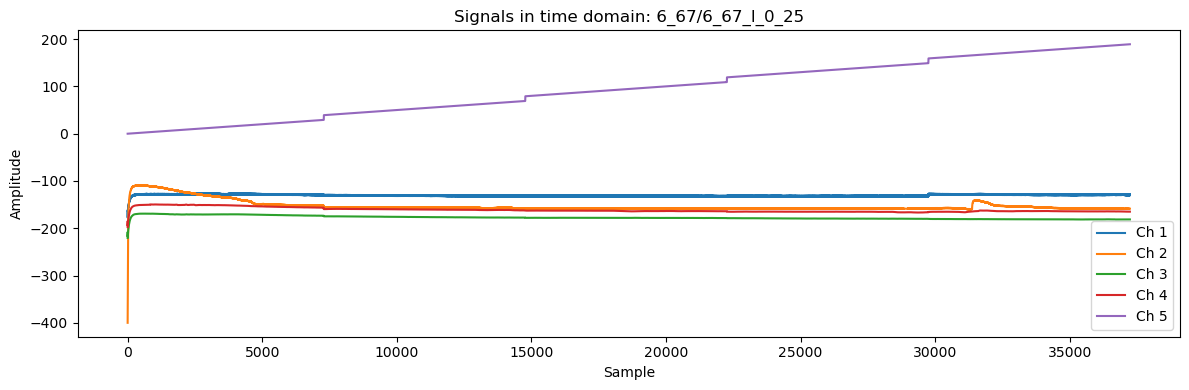

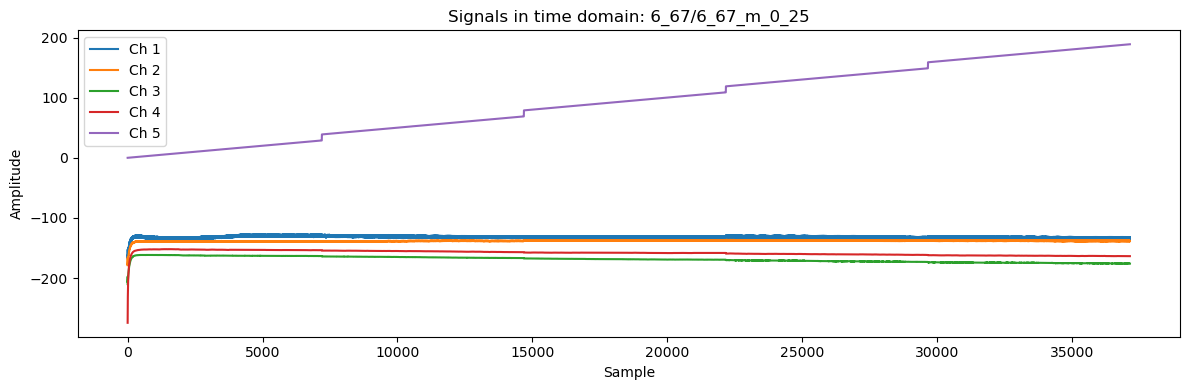

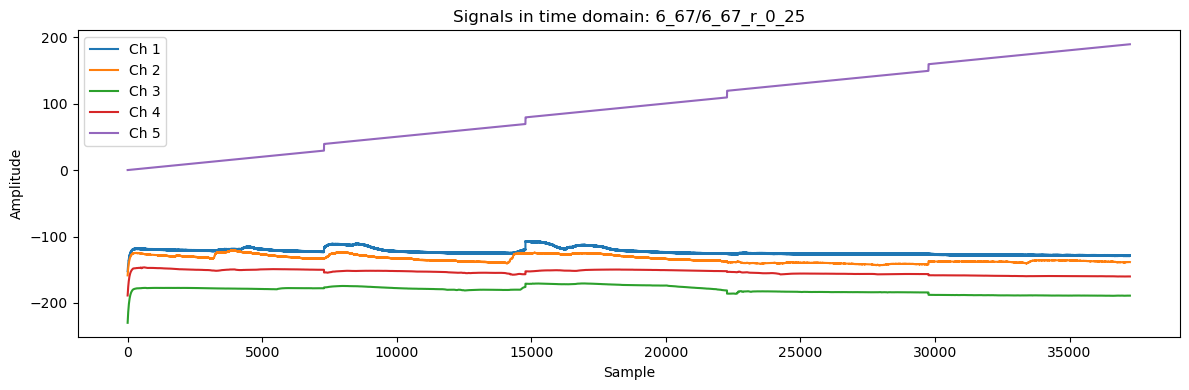

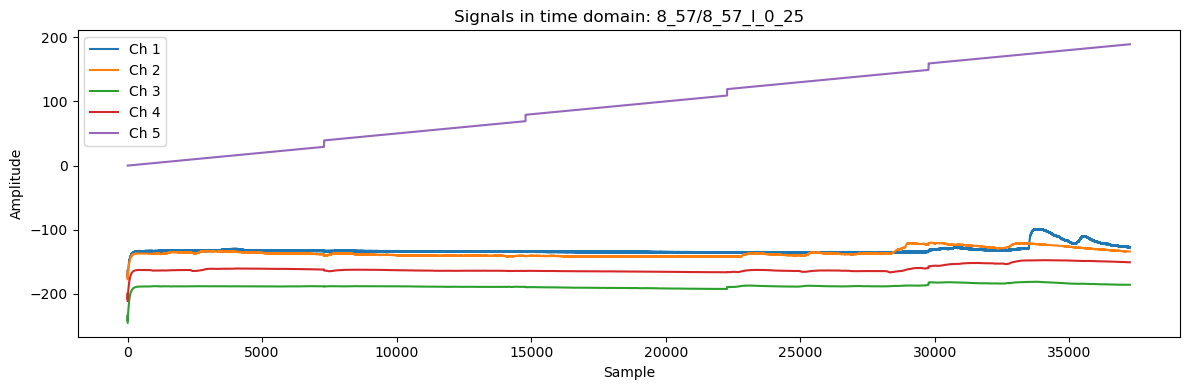

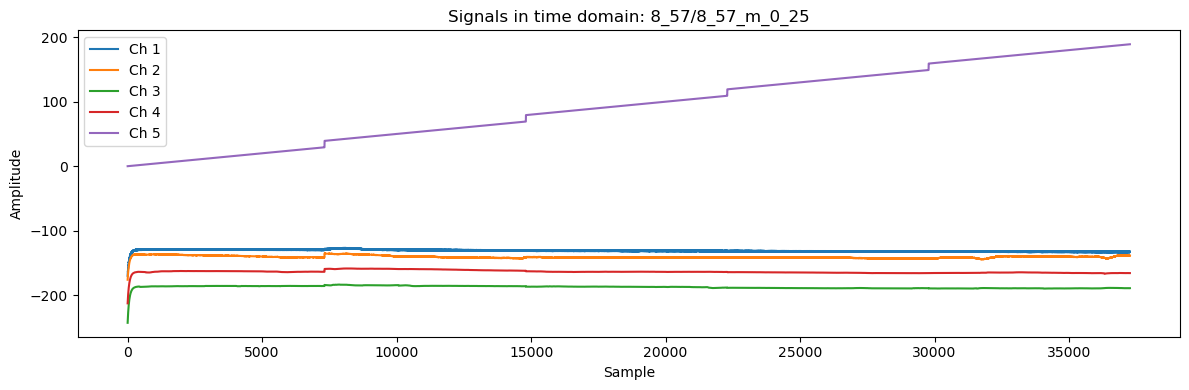

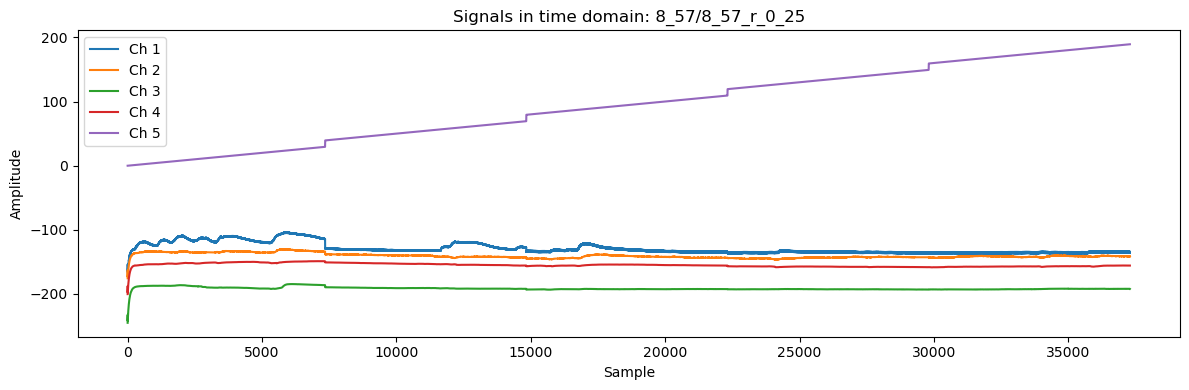

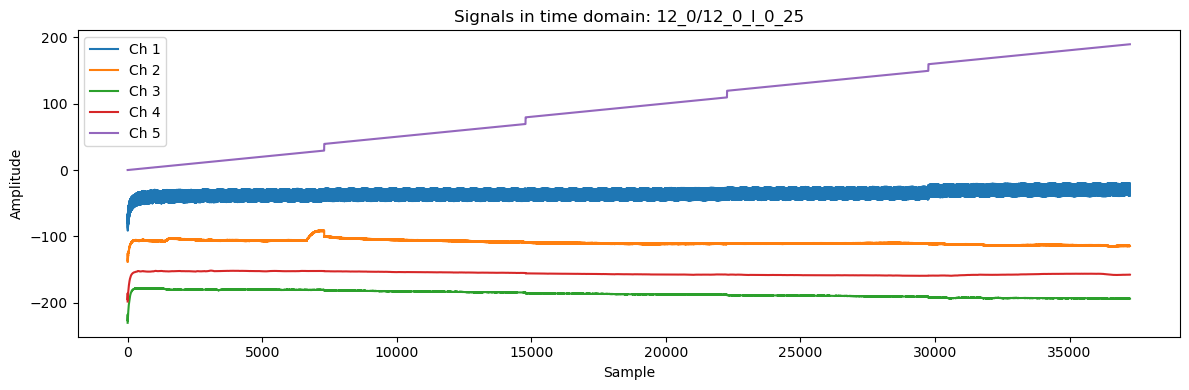

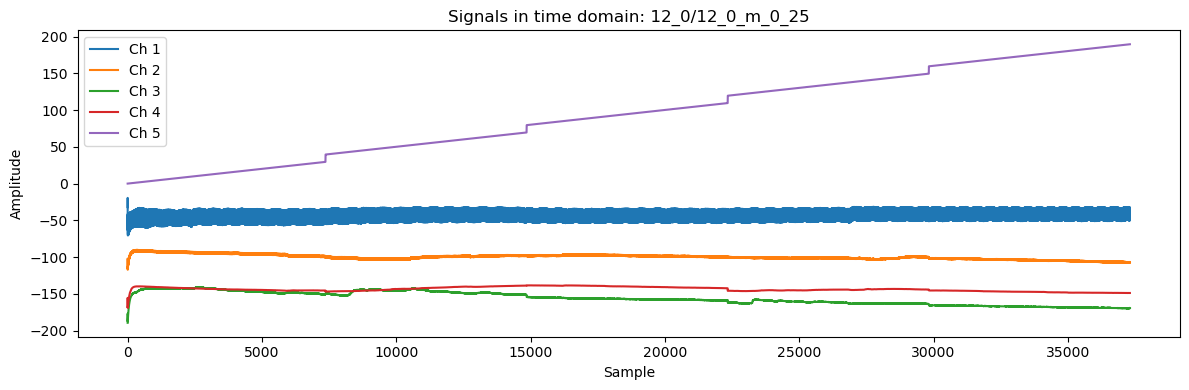

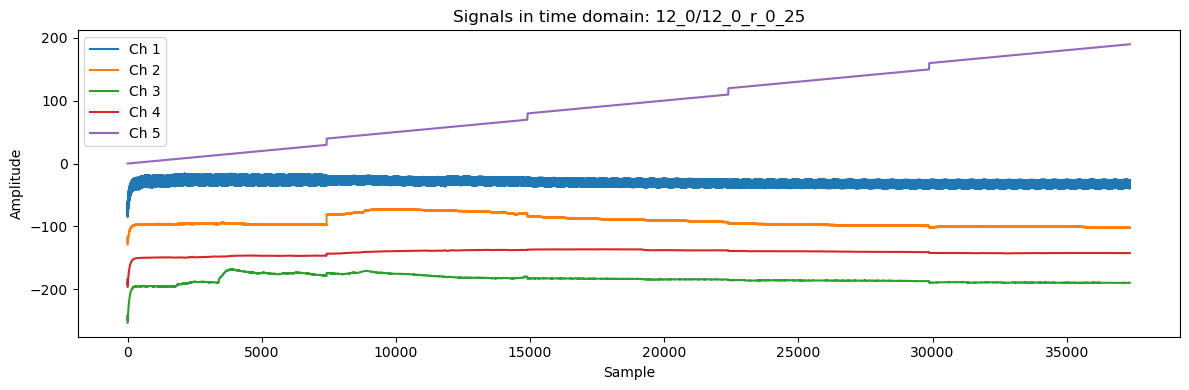

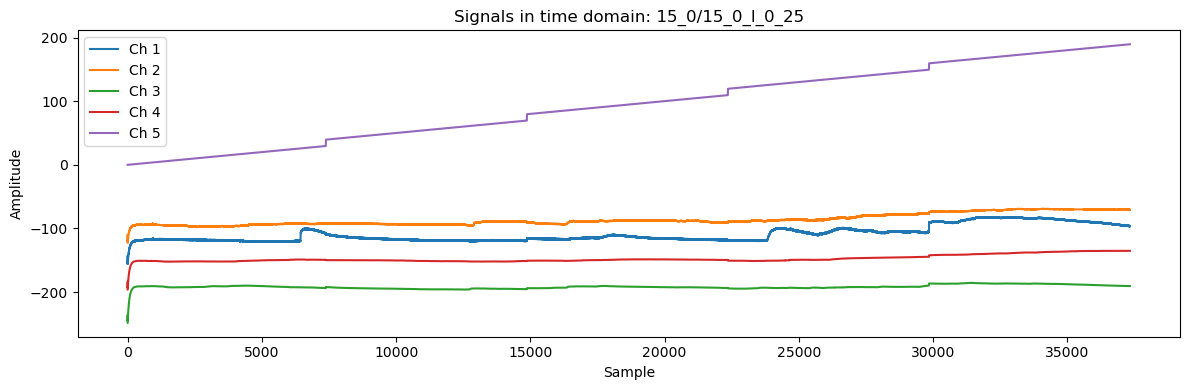

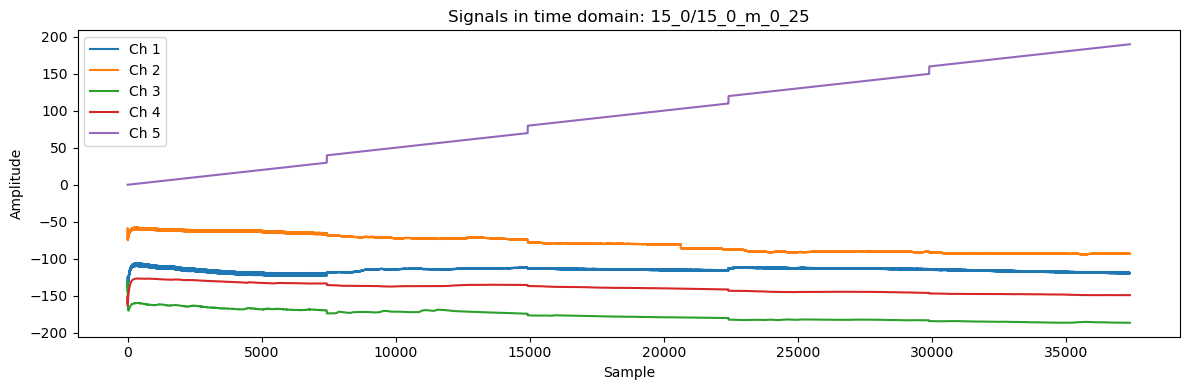

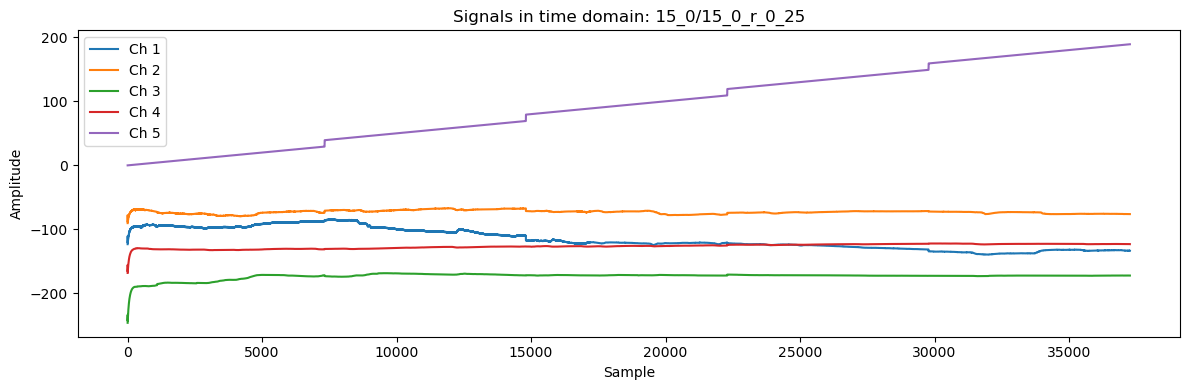

[✔] Saved raw and filtered plots for 6_67/6_67_l_0_25
[✔] Saved raw and filtered plots for 6_67/6_67_m_0_25
[✔] Saved raw and filtered plots for 6_67/6_67_r_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_l_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_m_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_r_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_l_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_m_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_r_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_l_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_m_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_r_0_25
[INFO] Dropping last 10 samples from 6_67_6_67_l_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_l_0_25
[INFO] Dropping last 35 samples from 6_67_6_67_m_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_m_0_25
[INFO] Dropping last 22 samples from 6_67_6_67_r_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_r_0_25
[INFO] 

/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 6_67/6_67_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 6_67/6_67_m_0_25: shape = (37146, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 6_67/6_67_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 6_67/6_67_r_0_25: shape = (37244, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 6_67/6_67_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_l_0_25: shape = (37250, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 8_57/8_57_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_m_0_25: shape = (37260, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 8_57/8_57_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_r_0_25: shape = (37288, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 8_57/8_57_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_l_0_25: shape = (37242, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 12_0/12_0_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_m_0_25: shape = (37308, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 12_0/12_0_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_r_0_25: shape = (37358, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 12_0/12_0_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_l_0_25: shape = (37330, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 15_0/15_0_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_m_0_25: shape = (37378, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 15_0/15_0_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_r_0_25: shape = (37264, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.4s.
[✘] ICA failed for 15_0/15_0_r_0_25: 'MNEFigure' object is not subscriptable
[✔] ICA 4x2 grid plot saved to graphs/subject1_t1_t2_poor/ica/ica_4x2_grid.png
Creating RawArray with float64 data, n_channels=4, n_times=37232
    Range : 0 ... 37231 =      0.000 ...   148.924 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_l_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37146
    Range : 0 ... 37145 =      0.000 ...   148.580 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_m_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37244
    Range : 0 ... 37243 =      0.000 ...   148.972 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_r_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37250
    Range : 0 ... 37249 =      0.000 ...   148.996 secs
Ready.
[✔] Saved components and sources for 8_57/8_57_l_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37260
    Range : 0 ... 37259 =   

KeyError: 'predictions'

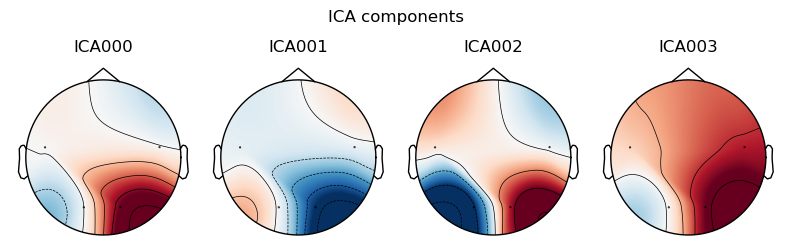

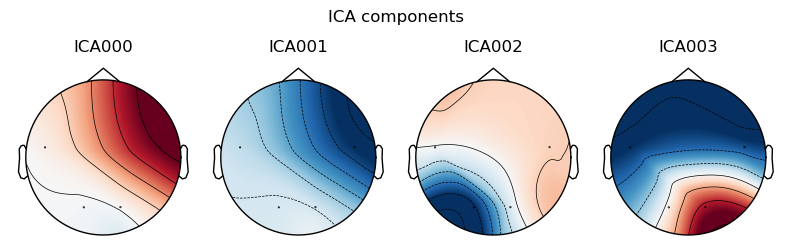

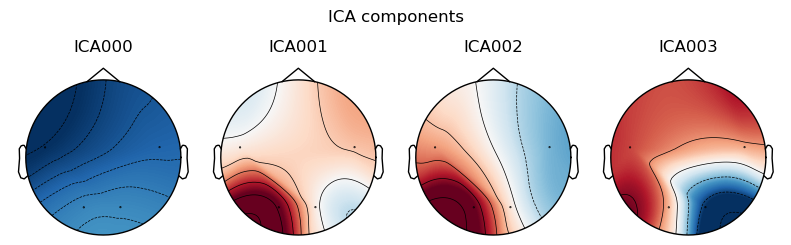

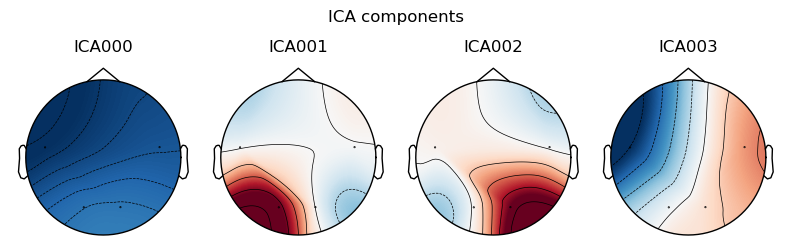

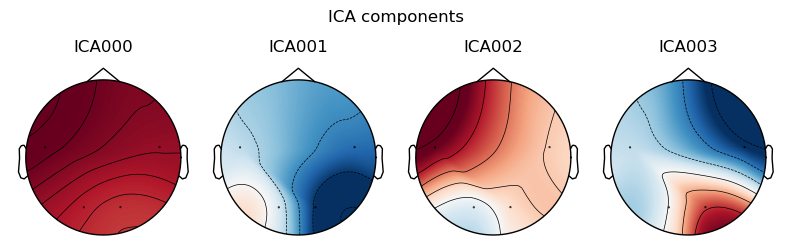

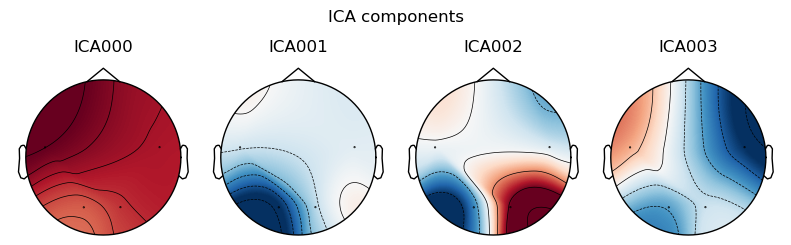

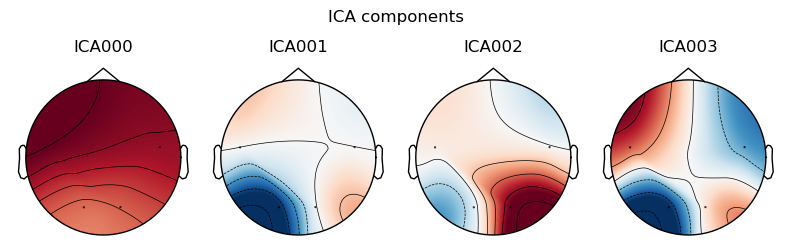

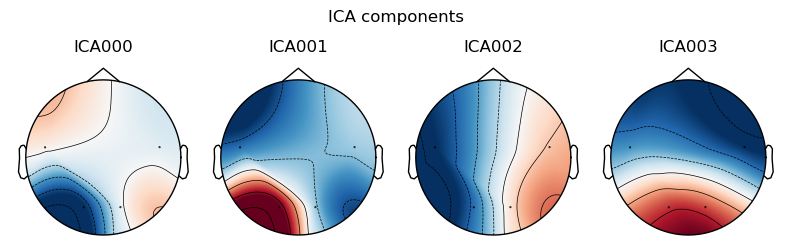

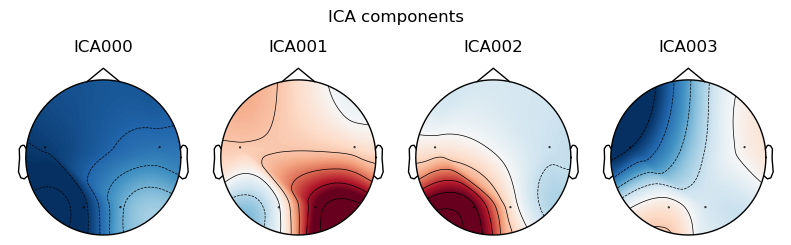

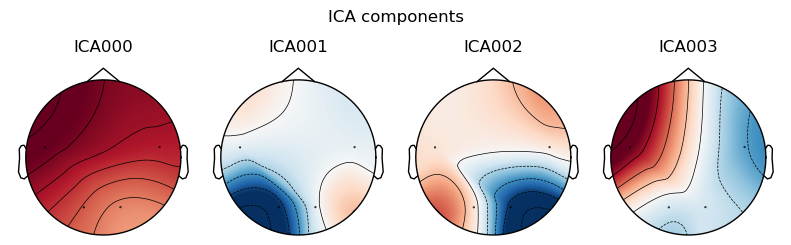

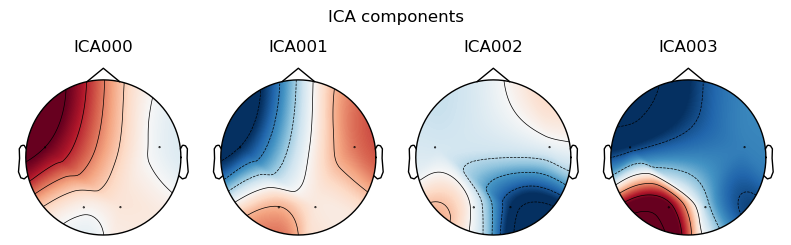

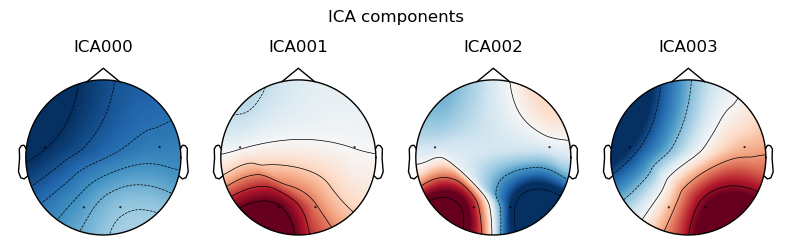

In [151]:
# === Konfigürasyonlar ===
frequencies = {
    '6_67': 6.67,
    '8_57': 8.57, 
    '12_0': 12.0,
    '15_0': 15.0
}

exclude_indices = {
    '6_67': {'6_67_m_1': [2, 3]},
    '8_57': {'8_57_m_1': [2, 3]},
    '12_0': {'12_0_m_1': [2, 3]},
    '15_0': {'15_0_m_1': [2, 3]}
}

epoch_params = {
    'duration': 29.5,   # Total epoch length (s)
    'trim_start': 1.0,  # Remove first 1s 
    'trim_end': 0.5     # Remove last 0.5s
}


subject="subject1_t1_t2_poor"
base_path = "/Users/hafizenursahbudak/Desktop/WiSe 24/IDP/neurosamples-main-python-BrainBitDemo_SSVEP/python/BrainBitDemo/wfdb_data/data/"
signals_dict, labels_dict, constants_dict = process_all_folders(base_path)
drop_zero_labels(signals_dict, labels_dict)
plot_signals(signals_dict)


filtered_data_dict = plot_raw_and_filtered(signals_dict, constants_dict)
process_windows_and_plot(filtered_data_dict, constants_dict)


ica_results = apply_ica_to_data(filtered_data_dict, constants_dict)
plot_ica_4x2_grid(ica_results)
plot_ica_components(ica_results)


cleaned_raws = apply_ica_cleaning(ica_results, exclude_indices)
results = run_cca_classification(cleaned_raws, frequencies, epoch_params)
print_final_report(results, frequencies)

plot_cca_results(results, frequencies)

process_cleaned_raws_with_windowing(cleaned_raws, window_size=250)

sub_results = run_subepoch_analysis(cleaned_raws, frequencies, epoch_params)



normalized_subepoch_results = run_subepoch_analysis_with_normalization(
    cleaned_raws,
    frequencies,
    epoch_params,
    subepoch_duration=4.0,
    overlap=0.0,
)



# Kullanım:
summarize_normalized_subepoch_results(normalized_subepoch_results, list(frequencies.values()))
minmax_results = run_subepoch_analysis_with_minmax(
    cleaned_raws, frequencies, epoch_params
)

summarize_normalized_subepoch_results(minmax_results, list(frequencies.values()))






=== Subepoch CCA Classification Summary ===
[!] Missing predictions in result for key: 6_67
[!] Missing predictions in result for key: 8_57
[!] Missing predictions in result for key: 12_0
[!] Missing predictions in result for key: 15_0


In [155]:


normalized_subepoch_results = run_subepoch_analysis_with_normalization(
    cleaned_raws,
    frequencies,
    epoch_params,
    subepoch_duration=4.0,
    overlap=0.0,
)

summarize_normalized_subepoch_results(normalized_subepoch_results, list(frequencies.values()))





=== 6_67 (6.67Hz) | Subfolder: l_0_25 ===
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
[Result] 6_67/l_0_25 → accuracy = 25.7%

=== 6_67 (6.67Hz) | Subfolder: m_0_25 ===
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
[Result] 6_67/m_0_25 → accuracy = 42.9%

=== 6_67 (6.67Hz) | Subfolder: r_0_25 ===
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
[Result] 6_67/r_0_25 → accuracy = 31.4%

=== 8_57 (8.57Hz) | Subfolder: l_0_25 ===
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items acti

In [161]:
minmax_results = run_subepoch_analysis_with_minmax(
    cleaned_raws, frequencies, epoch_params
)



summarize_normalized_subepoch_results(normalized_subepoch_results, list(frequencies.values()))


=== 6_67 (6.67Hz) | Subfolder: l_0_25 (Min–Max) ===
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
[Result] 6_67/l_0_25 → accuracy = 25.7%

=== 6_67 (6.67Hz) | Subfolder: m_0_25 (Min–Max) ===
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
[Result] 6_67/m_0_25 → accuracy = 42.9%

=== 6_67 (6.67Hz) | Subfolder: r_0_25 (Min–Max) ===
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7001 original time points ...
0 bad epochs dropped
[Result] 6_67/r_0_25 → accuracy = 31.4%

=== 8_57 (8.57Hz) | Subfolder: l_0_25 (Min–Max) ===
Not setting metadata
5 matching events found
No baseline co

In [162]:
results 

{'6_67': {'l_0_25': {'predictions': [6.67, 6.67, 8.57, 8.57, 6.67],
   'accuracy': 0.6,
   'epochs': <Epochs | 5 events (all good), 1 – 29 s (baseline off), ~1.1 MiB, data loaded,
    '1': 5>},
  'm_0_25': {'predictions': [6.67, 6.67, 8.57, 8.57, 6.67],
   'accuracy': 0.6,
   'epochs': <Epochs | 5 events (all good), 1 – 29 s (baseline off), ~1.1 MiB, data loaded,
    '1': 5>},
  'r_0_25': {'predictions': [6.67, 6.67, 8.57, 8.57, 6.67],
   'accuracy': 0.6,
   'epochs': <Epochs | 5 events (all good), 1 – 29 s (baseline off), ~1.1 MiB, data loaded,
    '1': 5>}},
 '8_57': {'l_0_25': {'predictions': [12.0, 8.57, 6.67, 8.57, 6.67],
   'accuracy': 0.4,
   'epochs': <Epochs | 5 events (all good), 1 – 29 s (baseline off), ~1.1 MiB, data loaded,
    '1': 5>},
  'm_0_25': {'predictions': [8.57, 8.57, 8.57, 8.57, 8.57],
   'accuracy': 1.0,
   'epochs': <Epochs | 5 events (all good), 1 – 29 s (baseline off), ~1.1 MiB, data loaded,
    '1': 5>},
  'r_0_25': {'predictions': [6.67, 8.57, 6.67, 6.67, 

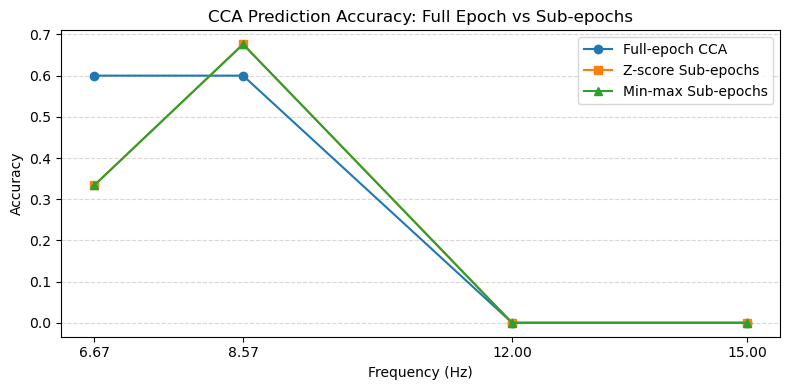

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Define your frequency keys
freq_keys   = ['6_67', '8_57', '12_0', '15_0']
frequencies = [float(k.replace('_', '.')) for k in freq_keys]

# Helper to compute accuracy from either a dict-of-dicts or plain list
def get_accuracy(entry, key):
    # entry might be {'l_0_25': {...}, ...} or a list of preds
    if isinstance(entry, dict):
        # dict-of-dicts case: average the stored 'accuracy'
        accs = [sub['accuracy'] for sub in entry.values() if isinstance(sub, dict) and 'accuracy' in sub]
        return np.mean(accs) if accs else np.nan
    elif isinstance(entry, list):
        # plain list of predictions
        target = float(key.replace('_', '.'))
        return np.mean([abs(p - target) < 0.5 for p in entry])
    else:
        return np.nan

# Compute full-epoch accuracy
acc_full = [get_accuracy(results[k], k) for k in freq_keys]

# Compute Z-score sub-epoch accuracy
acc_zscore = [get_accuracy(normalized_subepoch_results[k], k) for k in freq_keys]

# Compute Min-max sub-epoch accuracy
acc_minmax = [get_accuracy(minmax_results[k], k) for k in freq_keys]

# Plot everything on one figure
plt.figure(figsize=(8, 4))
plt.plot(frequencies, acc_full,   marker='o', label='Full-epoch CCA')
plt.plot(frequencies, acc_zscore, marker='s', label='Z-score Sub-epochs')
plt.plot(frequencies, acc_minmax, marker='^', label='Min-max Sub-epochs')

plt.xticks(frequencies)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Accuracy')
plt.title('CCA Prediction Accuracy: Full Epoch vs Sub-epochs')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


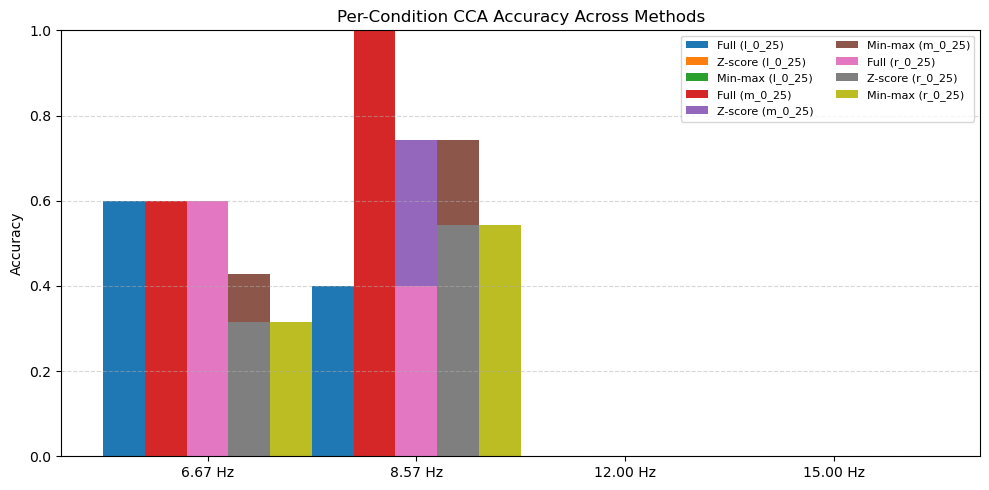

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your frequency keys and numeric values
freq_keys   = ['6_67', '8_57', '12_0', '15_0']
frequencies = [float(k.replace('_', '.')) for k in freq_keys]

# Map subfolder codes to descriptive labels
subfolders       = ['l_0_25', 'm_0_25', 'r_0_25']
subfolder_labels = {
    'l_0_25': 'Covert Left',
    'm_0_25': 'Overt',
    'r_0_25': 'Covert Right'
}

methods = ['Full', 'Z-score', 'Min-max']

# Gather accuracies: acc[method][freq_key][subfolder_index]
acc = {m: {k: [] for k in freq_keys} for m in methods}

for k in freq_keys:
    for sf in subfolders:
        acc['Full'][k].append(results[k][sf]['accuracy'])
        acc['Z-score'][k].append(normalized_subepoch_results[k][sf]['accuracy'])
        acc['Min-max'][k].append(minmax_results[k][sf]['accuracy'])

# Plot grouped bars
x = np.arange(len(freq_keys))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))
for i, sf in enumerate(subfolders):
    label_center = x  # frequency positions
    # Full-epoch bars (shift left)
    ax.bar(label_center + (i-1)*width*3/2 - width, 
           [acc['Full'][k][i] for k in freq_keys], 
           width, label=f'Full – {subfolder_labels[sf]}')
    # Z-score bars (center)
    ax.bar(label_center + (i-1)*width*3/2, 
           [acc['Z-score'][k][i] for k in freq_keys], 
           width, label=f'Z-score – {subfolder_labels[sf]}')
    # Min-max bars (shift right)
    ax.bar(label_center + (i-1)*width*3/2 + width,
           [acc['Min-max'][k][i] for k in freq_keys], 
           width, label=f'Min-max – {subfolder_labels[sf]}')

ax.set_xticks(x)
ax.set_xticklabels([f"{f:.2f} Hz" for f in frequencies])
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy')
ax.set_title('CCA Accuracy by Frequency, Method & Attention Condition')
ax.legend(loc='upper right', ncol=2, fontsize=8)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


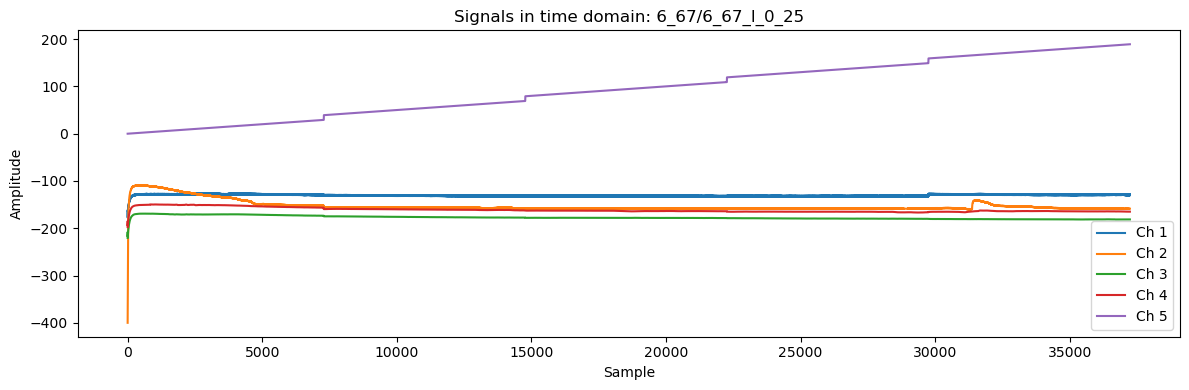

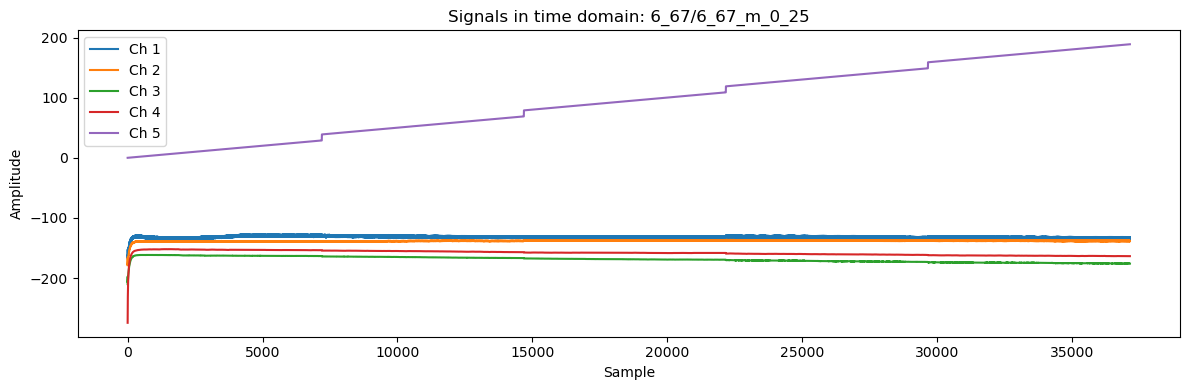

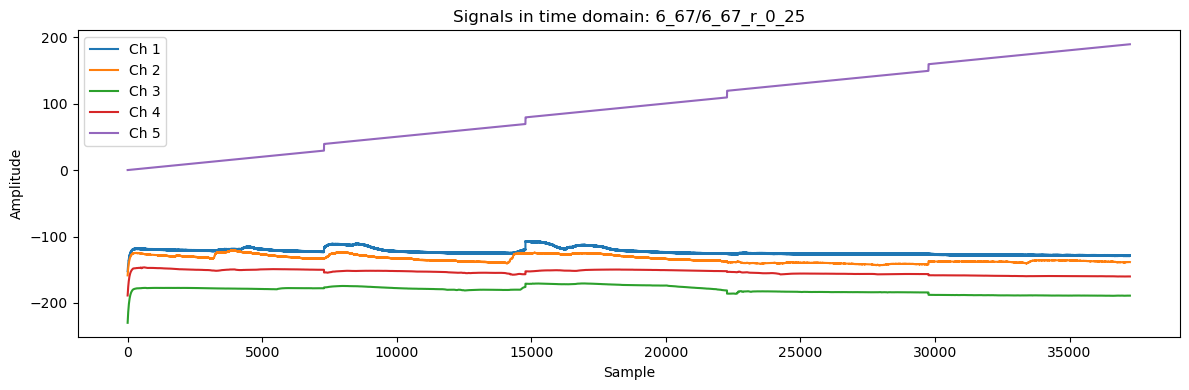

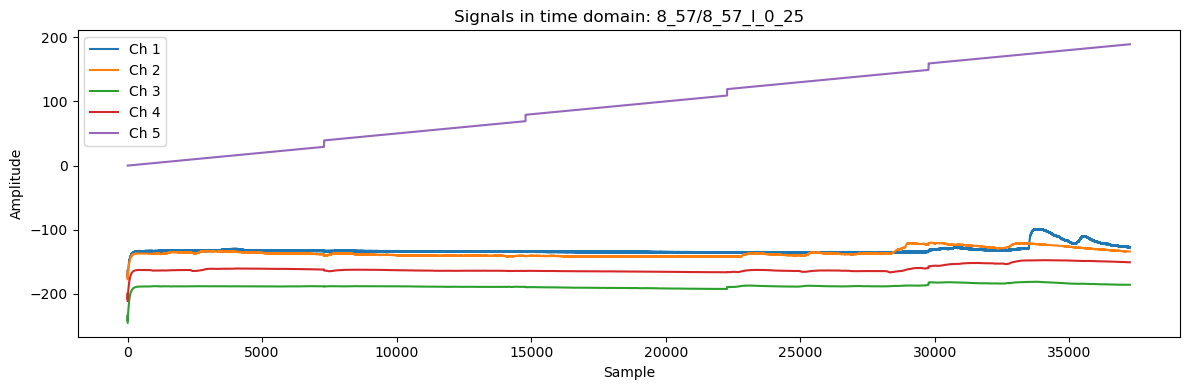

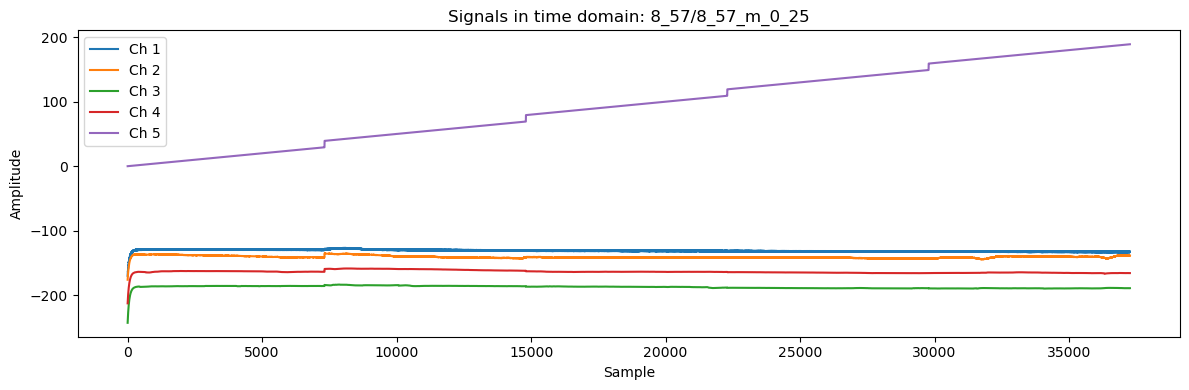

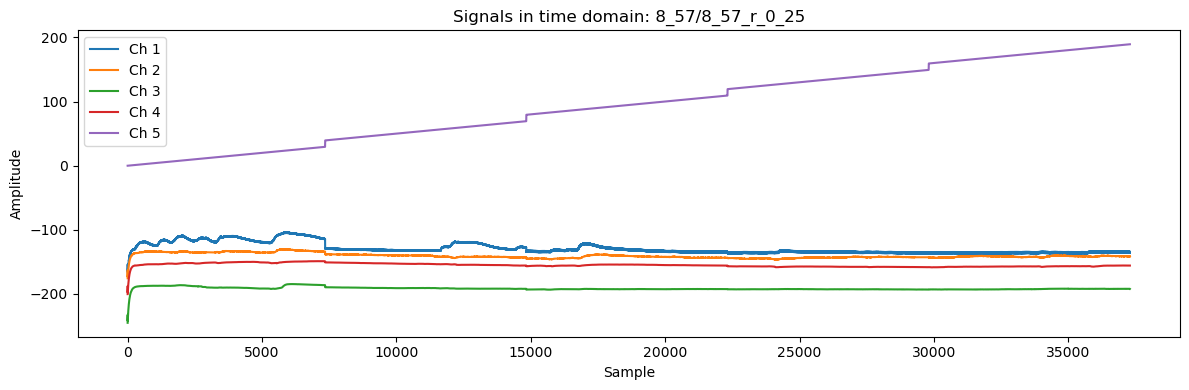

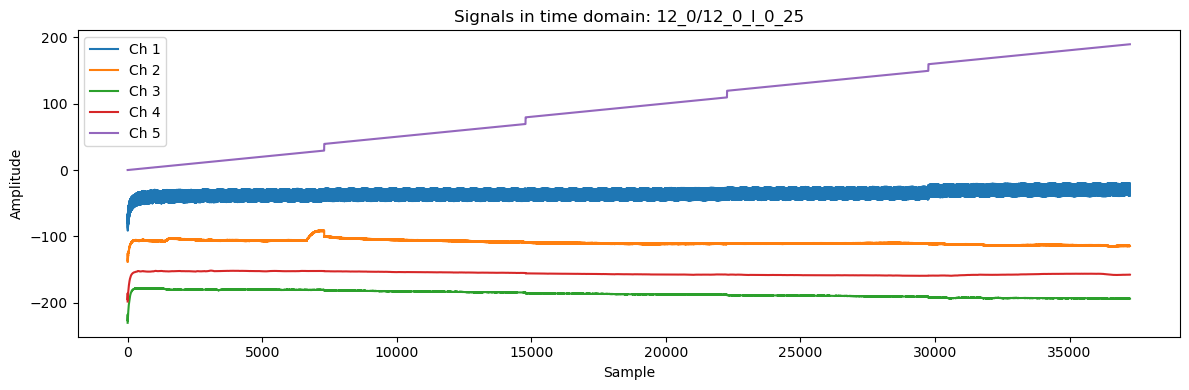

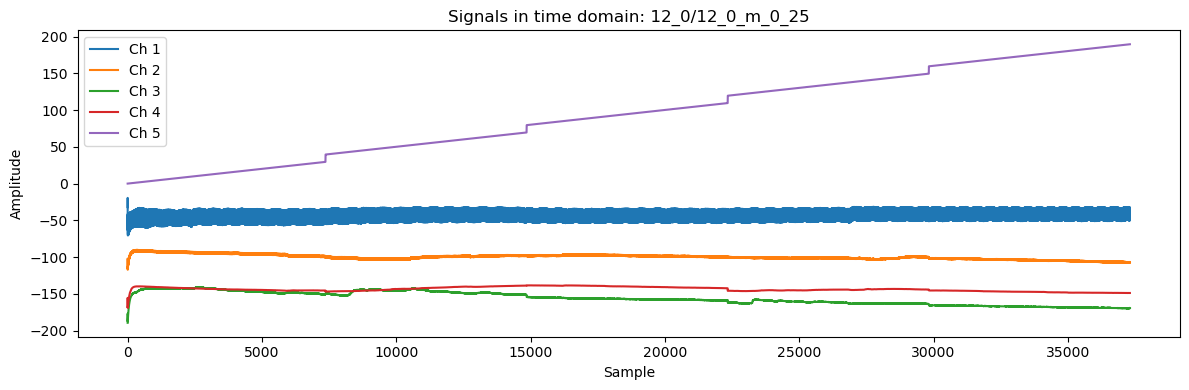

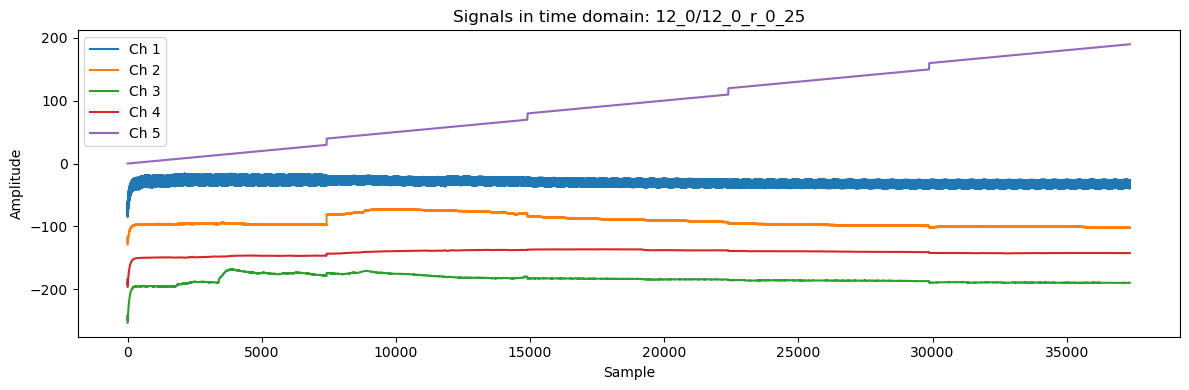

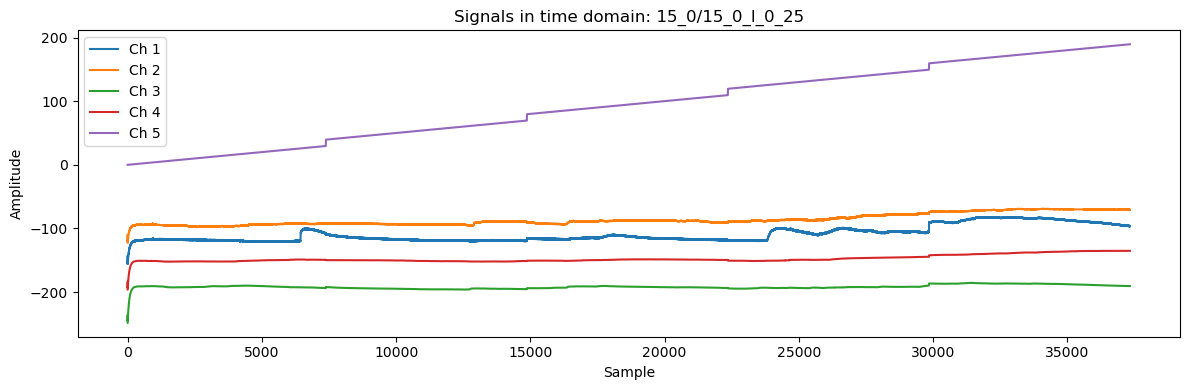

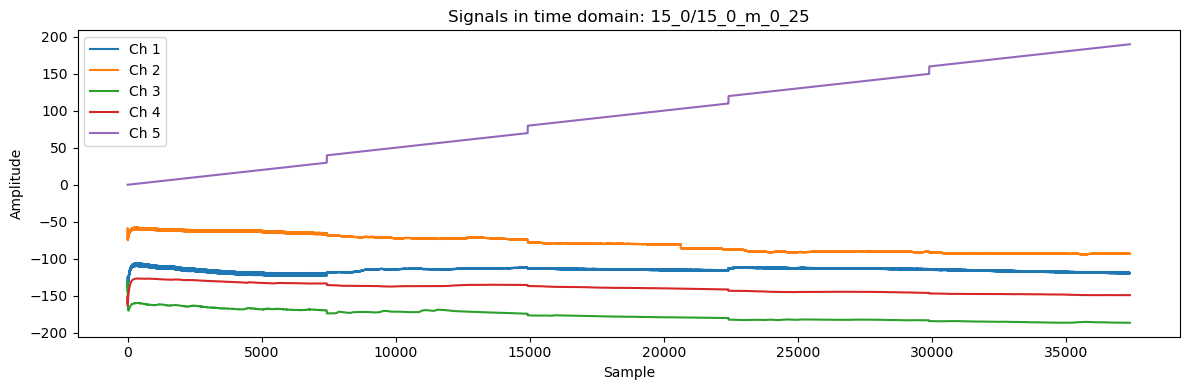

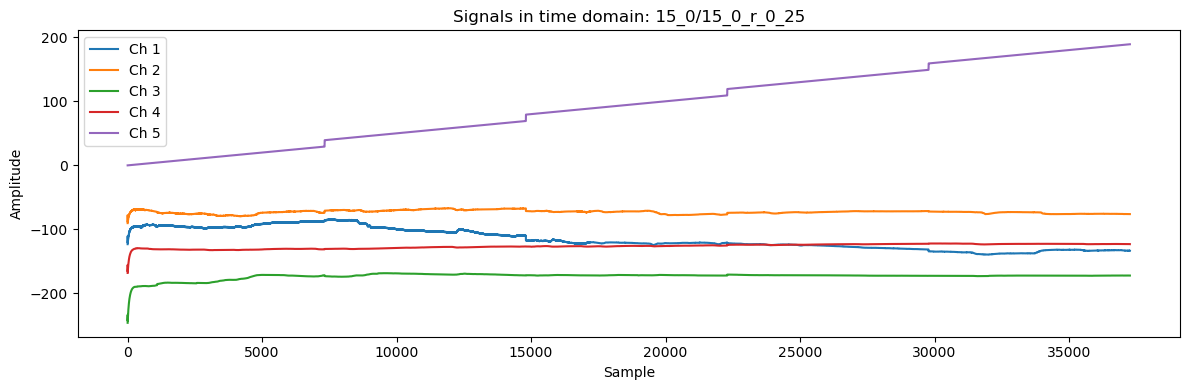

[✔] Saved raw and filtered plots for 6_67/6_67_l_0_25
[✔] Saved raw and filtered plots for 6_67/6_67_m_0_25
[✔] Saved raw and filtered plots for 6_67/6_67_r_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_l_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_m_0_25
[✔] Saved raw and filtered plots for 8_57/8_57_r_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_l_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_m_0_25
[✔] Saved raw and filtered plots for 12_0/12_0_r_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_l_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_m_0_25
[✔] Saved raw and filtered plots for 15_0/15_0_r_0_25
[INFO] Dropping last 10 samples from 6_67_6_67_l_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_l_0_25
[INFO] Dropping last 35 samples from 6_67_6_67_m_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_m_0_25
[INFO] Dropping last 22 samples from 6_67_6_67_r_0_25
[✔] Saved windowed and normalized plots for 6_67_6_67_r_0_25
[INFO] 

/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 6_67/6_67_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 6_67/6_67_m_0_25: shape = (37146, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 6_67/6_67_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 6_67/6_67_r_0_25: shape = (37244, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 6_67/6_67_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_l_0_25: shape = (37250, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 8_57/8_57_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_m_0_25: shape = (37260, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 8_57/8_57_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 8_57/8_57_r_0_25: shape = (37288, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 8_57/8_57_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_l_0_25: shape = (37242, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 12_0/12_0_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_m_0_25: shape = (37308, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 12_0/12_0_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 12_0/12_0_r_0_25: shape = (37358, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 12_0/12_0_r_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_l_0_25: shape = (37330, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.2s.
[✘] ICA failed for 15_0/15_0_l_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_m_0_25: shape = (37378, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.4s.
[✘] ICA failed for 15_0/15_0_m_0_25: 'MNEFigure' object is not subscriptable
[→] Processing 15_0/15_0_r_0_25: shape = (37264, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.5s.
[✘] ICA failed for 15_0/15_0_r_0_25: 'MNEFigure' object is not subscriptable
[✔] ICA 4x2 grid plot saved to graphs/subject1_t1_t2_poor/ica/ica_4x2_grid.png
Creating RawArray with float64 data, n_channels=4, n_times=37232
    Range : 0 ... 37231 =      0.000 ...   148.924 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_l_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37146
    Range : 0 ... 37145 =      0.000 ...   148.580 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_m_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37244
    Range : 0 ... 37243 =      0.000 ...   148.972 secs
Ready.
[✔] Saved components and sources for 6_67/6_67_r_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37250
    Range : 0 ... 37249 =      0.000 ...   148.996 secs
Ready.
[✔] Saved components and sources for 8_57/8_57_l_0_25
Creating RawArray with float64 data, n_channels=4, n_times=37260
    Range : 0 ... 37259 =   

KeyError: 'predictions'

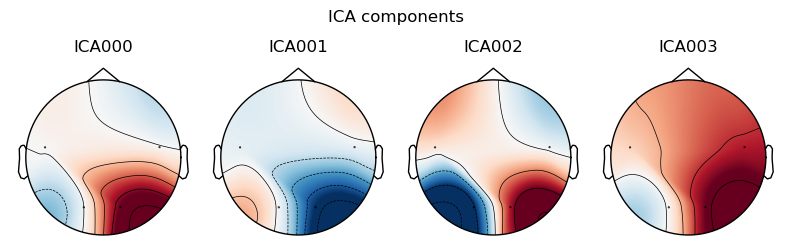

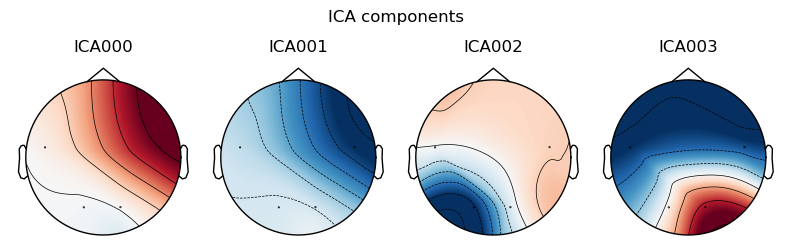

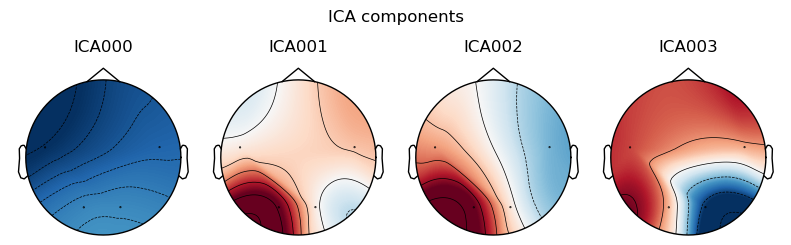

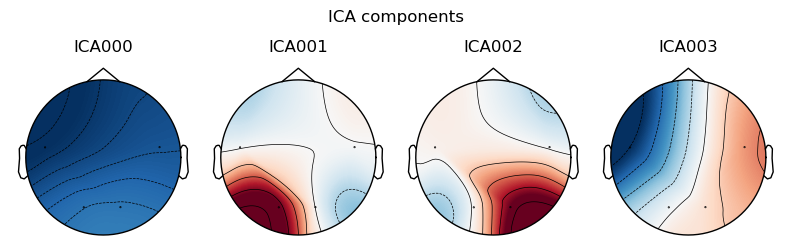

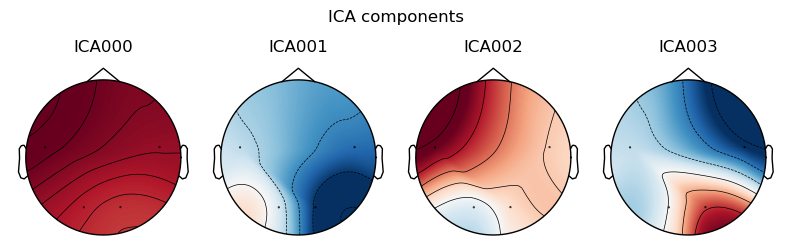

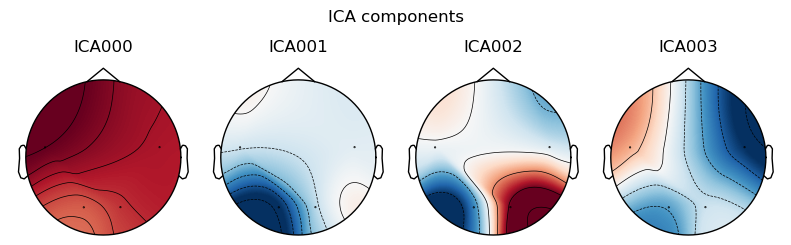

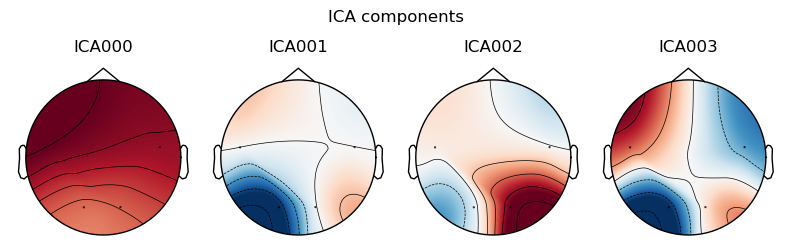

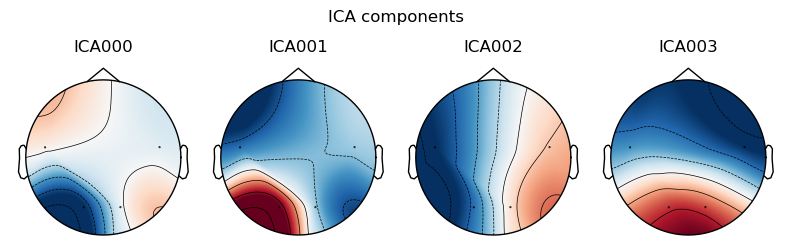

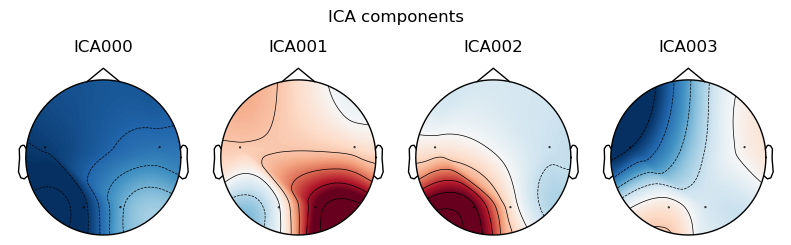

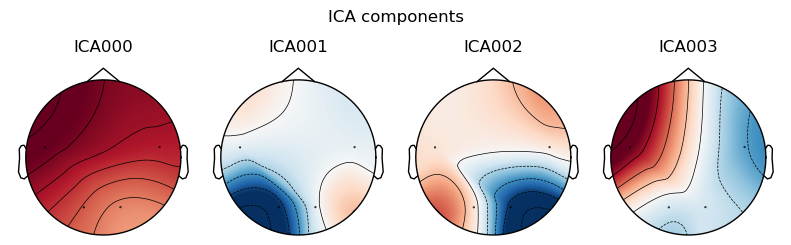

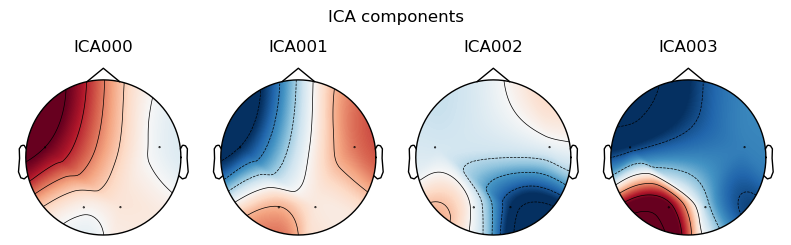

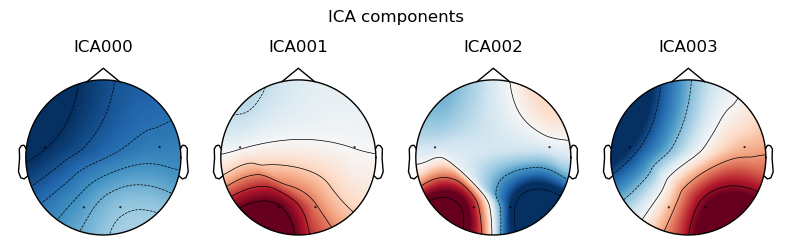

In [ ]:
# === Konfigürasyonlar ===

subject = "subject1_t1_t2_poor"  

constants_map = {
        "6_67": {"sampling_rate": 250, "low_cutoff": 1, "high_cutoff": 40, "notch_freq": 50.0, "window_size": 37, "k": 200, "sec": 150},
        "8_57": {"sampling_rate": 250, "low_cutoff": 1, "high_cutoff": 40, "notch_freq": 50.0, "window_size": 29, "k": 257, "sec": 117},
        "12_0": {"sampling_rate": 250, "low_cutoff": 1, "high_cutoff": 40, "notch_freq": 50.0, "window_size": 20, "k": 360, "sec": 83},
        "15_0": {"sampling_rate": 250, "low_cutoff": 1, "high_cutoff": 40, "notch_freq": 50.0, "window_size": 16, "k": 450, "sec": 67},
        "1_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff":55 , "notch_freq": 50.0, "window_size": 147, "k": 51, "sec": 580},
        "10_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55, "notch_freq": 50.0, "window_size": 23, "k": 321, "sec": 94},
        "20_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55, "notch_freq": 50.0, "window_size": 12, "k": 621, "sec": 48},
        "30_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55.0, "notch_freq": 50.0, "window_size": 8, "k": 921, "sec": 32},
        "40_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55.0, "notch_freq": 50.0, "window_size": 6, "k": 1221, "sec": 25},
        "50_7": {"sampling_rate": 250, "low_cutoff": 0.5, "high_cutoff": 55.0, "notch_freq": 50.0, "window_size": 5, "k": 1521, "sec": 20},
    }
comparison_folders = ["6_67", "8_57", "12_0", "15_0"]
subfolders = ["l_0_25", "m_0_25", "r_0_25"]


frequencies = {
    '6_67': 6.67,
    '8_57': 8.57, 
    '12_0': 12.0,
    '15_0': 15.0
}

exclude_indices = {
    '6_67': {'6_67_m_1': [2, 3]},
    '8_57': {'8_57_m_1': [2, 3]},
    '12_0': {'12_0_m_1': [2, 3]},
    '15_0': {'15_0_m_1': [2, 3]},
}

epoch_params = {
    'duration': 29.5,   # Total epoch length (s)
    'trim_start': 1.0,  # Remove first 1s 
    'trim_end': 0.5     # Remove last 0.5s
}


def pipeline(subject="subject1_t1_t2_poor"):
    subject = subject
    signals_dict, labels_dict, constants_dict = process_all_folders(base_path)
    drop_zero_labels(signals_dict, labels_dict)
    plot_signals(signals_dict)


    filtered_data_dict = plot_raw_and_filtered(signals_dict, constants_dict)
    process_windows_and_plot(filtered_data_dict, constants_dict)


    ica_results = apply_ica_to_data(filtered_data_dict, constants_dict)
    plot_ica_4x2_grid(ica_results)
    plot_ica_components(ica_results)


    cleaned_raws = apply_ica_cleaning(ica_results, exclude_indices)
    results = run_cca_classification(cleaned_raws, frequencies, epoch_params)
    print_final_report(results, frequencies)

    plot_cca_results(results, frequencies)

    sub_results = run_subepoch_analysis(cleaned_raws, frequencies, epoch_params)


    normalized_subepoch_results = run_subepoch_analysis_with_normalization(
        cleaned_raws,
        frequencies,
        epoch_params,
        subepoch_duration=4.0,
        overlap=0.0,
      
    )

    


    # Kullanım:
    summarize_normalized_subepoch_results(normalized_subepoch_results, list(frequencies.values()))
    minmax_results = run_subepoch_analysis_with_minmax(
        cleaned_raws, frequencies, epoch_params
    )

    summarize_normalized_subepoch_results(minmax_results, list(frequencies.values()))


    process_cleaned_raws_with_windowing(cleaned_raws, window_size=250)

    return results, normalized_subepoch_results, minmax_results
    
results,normalized_subepoch_results,minmax_results =  pipeline(subject)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Define the stimulus keys and human-readable labels
freq_keys = ['6_67', '8_57', '12_0', '15_0']
labels = [f"{float(k.replace('_','.')):.2f} Hz" for k in freq_keys]

# 2) Extract each method’s accuracy
# Full-epoch CCA (you computed this in run_cca_classification; it's in results[k]['accuracy'])
acc_full    = [results[k]['accuracy'] for k in freq_keys]

# Sub-epoch CCA with Z-score normalization
acc_zscore  = [
    np.mean([abs(p - float(k.replace('_','.'))) < 0.5
             for p in normalized_subepoch_results[k]['predictions']])
    for k in freq_keys
]

# Sub-epoch CCA with Min-Max normalization
acc_minmax  = [
    np.mean([abs(p - float(k.replace('_','.'))) < 0.5
             for p in minmax_results[k]['predictions']])
    for k in freq_keys
]

# 3) Plot them in one grouped bar chart
x     = np.arange(len(freq_keys))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width, acc_full,    width, label='Full-epoch CCA')
ax.bar(x,         acc_zscore, width, label='Z-score Sub-epochs')
ax.bar(x + width, acc_minmax, width, label='MinMax Sub-epochs')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy')
ax.set_title('Prediction Accuracy by Frequency & Normalization')
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


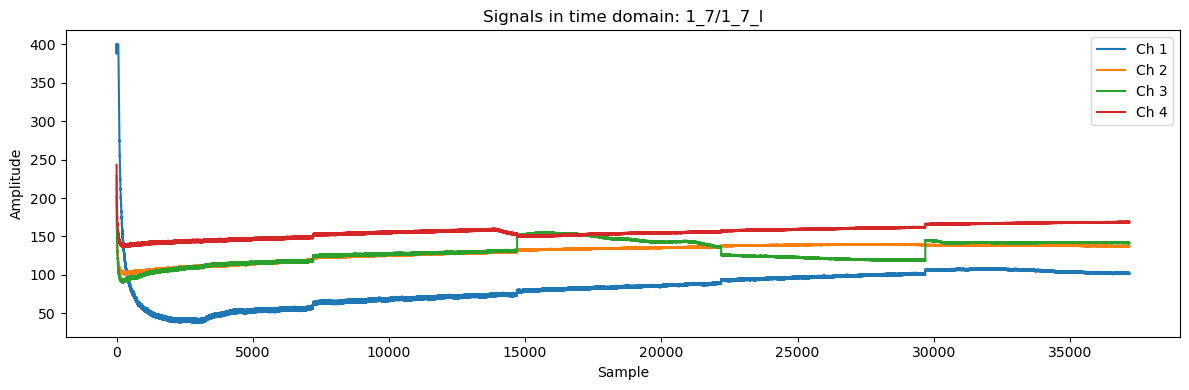

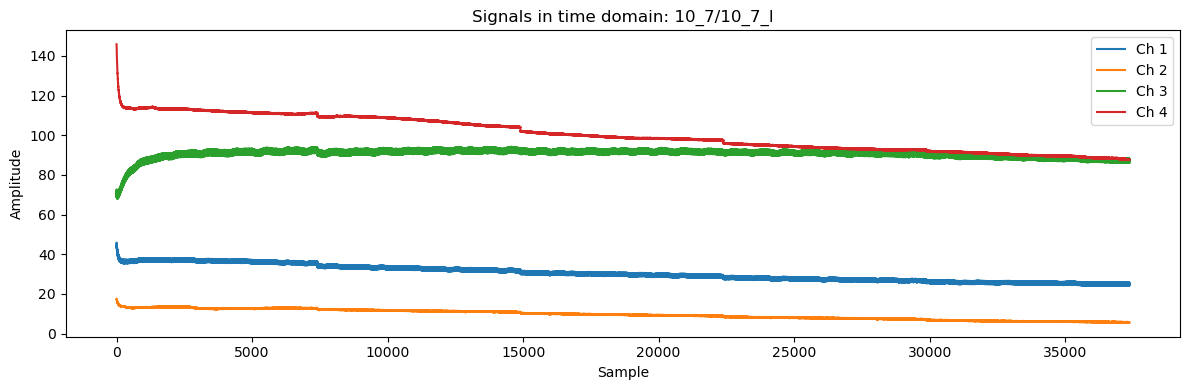

[✔] Saved raw and filtered plots for 1_7/1_7_l
[✔] Saved raw and filtered plots for 10_7/10_7_l
[INFO] Dropping last 140 samples from 1_7_1_7_l
[✔] Saved windowed and normalized plots for 1_7_1_7_l
[INFO] Dropping last 14 samples from 10_7_10_7_l
[✔] Saved windowed and normalized plots for 10_7_10_7_l
[→] Processing 1_7/1_7_l: shape = (37184, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


[✘] ICA failed for 1_7/1_7_l: 'MNEFigure' object is not subscriptable
[→] Processing 10_7/10_7_l: shape = (37366, 4)
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


/var/folders/91/rv96374n55s_70dpnyn83xfm0000gn/T/ipykernel_21483/801694070.py:33: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
[✘] ICA failed for 10_7/10_7_l: 'MNEFigure' object is not subscriptable
[✔] ICA 4x2 grid plot saved to graphs/comparison_covert_check_resistance_juliana/ica/ica_4x2_grid.png
Creating RawArray with float64 data, n_channels=4, n_times=37184
    Range : 0 ... 37183 =      0.000 ...   148.732 secs
Ready.
[✔] Saved components and sources for 1_7/1_7_l
Creating RawArray with float64 data, n_channels=4, n_times=37366
    Range : 0 ... 37365 =      0.000 ...   149.460 secs
Ready.
[✔] Saved components and sources for 10_7/10_7_l
[ICA] 1_7/1_7_l excluded: [2, 3]
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 4 PCA components
[ICA] 10_7/10_7_l excluded: [2, 3]
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 4 PCA components

=== CCA Processing 1_7 (1.7Hz) ===
Not setting metadata
5 matching events found
No

TypeError: run_subepoch_analysis_with_normalization() got an unexpected keyword argument 'save_dir'

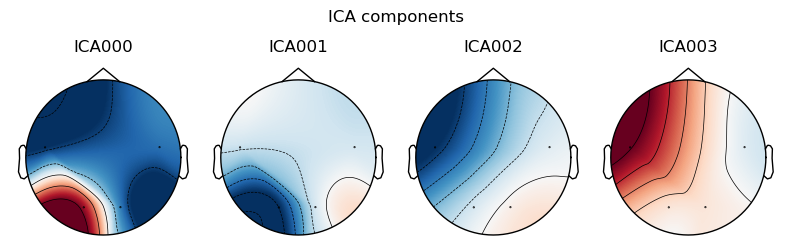

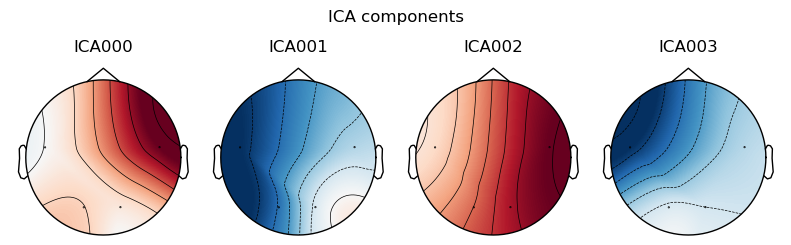

In [115]:
subject="comparison_covert_check_resistance_juliana"

comparison_folders = ["1_7", "10_7"]
subfolders = ["l"]

frequencies = {
    '1_7': 1.7,
    '10_7': 10.7, 

}

exclude_indices = {
    '1_7': {'1_7_l': [2, 3]},
    '10_7': {'10_7_l': [2, 3]},
}

epoch_params = {
    'duration': 29.5,   # Total epoch length (s)
    'trim_start': 1.0,  # Remove first 1s 
    'trim_end': 0.5     # Remove last 0.5s
}

pipeline(subject)